In [55]:
import pickle
from collections import namedtuple
import pandas as pd
import numpy as np
from importlib import reload
import sys
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import datetime

# bench_util module is in the parent directory, because it will be part of
# the production code.  Add the parent directory to the Path so Python can
# import from there
sys.path.insert(0, '../')   
import bench_util as bu
import graph_util as gu

## Unpickle the Dataframe for Preprocessed Utility Data & Make Utility Function Object

In [56]:
# Unpickle the pre-processed DataFrame
df = pickle.load(open('dfu3.pkl', 'rb'))

# Unpickle the raw utility bill DataFrame, which is needed below to make
# the utility function object.
df_raw = pickle.load(open('df_raw.pkl', 'rb'))

df.head()  # the processed data

,site_id,service_type,cal_year,cal_mo,item_desc,units,cost,days_served,usage,fiscal_year,fiscal_mo,mmbtu
0,03,Electricity,2005,12,Electricity charge,kWh,1904.657880,49.5,14790.748577,2006,6,50.466034
1,03,Electricity,2006,1,Electricity charge,kWh,5430.493797,93.0,42665.790911,2006,7,145.575679
2,03,Electricity,2006,2,Electricity charge,kWh,5764.406730,84.0,45010.439348,2006,8,153.575619
3,03,Electricity,2006,3,Electricity charge,kWh,6349.255299,93.0,46311.547557,2006,9,158.015000
4,03,Electricity,2006,4,Electricity charge,kWh,5529.385224,90.0,40392.812893,2006,10,137.820278


In [57]:
# this is only needed to update any code changes I may have made
# since last importing the module above.
reload(bu) 
reload(gu)

# Make an object that has the various utility functions.
# The object needs access to the raw utility bill DataFrame and the spreadsheet
# containing other application data.
ut = bu.Util(df_raw, '../data/Other_Building_Data.xlsx')

In [58]:
# Testing site.  Final code will loop through all sites
site = 'DIPMP1'

In [59]:
template_data = {}

# Energy Use Overview Report - Page 4


In [60]:
# From the main DataFrame, get only the rows for this site, and only get
# the needed columns for this analysis
usage_df1 = df.query('site_id == @site')[['service_type', 'fiscal_year', 'fiscal_mo', 'mmbtu']]
usage_df1.head()

,service_type,fiscal_year,fiscal_mo,mmbtu
48636,Electricity,2006,12,85.16352
48637,Electricity,2006,12,0.00000
48638,Electricity,2006,12,NaN
48639,Electricity,2007,1,160.70520
48640,Electricity,2007,1,0.00000


In [61]:
usage_df2 = pd.pivot_table(
    usage_df1, 
    values='mmbtu', 
    index=['fiscal_year'], 
    columns=['service_type'],
    aggfunc=np.sum
)

usage_df2 = usage_df2.drop(labels=['Sewer', 'Water'], axis=1)

usage_df2

service_type,Electricity,Natural Gas,Oil #1
fiscal_year,,,
2006,85.163520,NaN,56.806579
2007,4062.988275,NaN,725.280637
2008,4475.848805,NaN,736.426534
2009,4683.474489,5199.297000,2112.606964
2010,4984.455578,566.276800,6879.015877
2011,4656.171492,1139.153000,6259.229880
2012,4516.043334,7309.068619,668.293467
2013,4760.229306,7748.241853,798.431211
2014,4665.265022,7340.779372,612.212365


In [62]:
# Add in columns for the missing services
missing_services = bu.missing_energy_services(usage_df2.columns)
bu.add_columns(usage_df2, missing_services)
usage_df2

service_type,Electricity,Natural Gas,Oil #1,Steam
fiscal_year,,,,
2006,85.163520,NaN,56.806579,0.0
2007,4062.988275,NaN,725.280637,0.0
2008,4475.848805,NaN,736.426534,0.0
2009,4683.474489,5199.297000,2112.606964,0.0
2010,4984.455578,566.276800,6879.015877,0.0
2011,4656.171492,1139.153000,6259.229880,0.0
2012,4516.043334,7309.068619,668.293467,0.0
2013,4760.229306,7748.241853,798.431211,0.0
2014,4665.265022,7340.779372,612.212365,0.0


In [63]:
# Add a Total column that sums the other columns
usage_df2['total_energy'] = usage_df2.sum(axis=1)
cols = ['{}_mmbtu'.format(bu.change_name(col)) for col in usage_df2.columns]
usage_df2.columns = cols
usage_df2

,electricity_mmbtu,natural_gas_mmbtu,fuel_oil_mmbtu,district_heat_mmbtu,total_energy_mmbtu
fiscal_year,,,,,
2006,85.163520,NaN,56.806579,0.0,141.970099
2007,4062.988275,NaN,725.280637,0.0,4788.268912
2008,4475.848805,NaN,736.426534,0.0,5212.275339
2009,4683.474489,5199.297000,2112.606964,0.0,11995.378453
2010,4984.455578,566.276800,6879.015877,0.0,12429.748255
2011,4656.171492,1139.153000,6259.229880,0.0,12054.554371
2012,4516.043334,7309.068619,668.293467,0.0,12493.405421
2013,4760.229306,7748.241853,798.431211,0.0,13306.902370
2014,4665.265022,7340.779372,612.212365,0.0,12618.256760


In [64]:
# Create a list of columns to loop through and calculate percent total energy
usage_cols = list(usage_df2.columns.values)
print (usage_cols)
usage_cols.remove('total_energy_mmbtu')

for col in usage_cols:
    col_name = col.split('_mmbtu')[0] + "_pct"
    usage_df2[col_name] = usage_df2[col] / usage_df2.total_energy_mmbtu

usage_df2

['electricity_mmbtu', 'natural_gas_mmbtu', 'fuel_oil_mmbtu', 'district_heat_mmbtu', 'total_energy_mmbtu']


,electricity_mmbtu,natural_gas_mmbtu,fuel_oil_mmbtu,district_heat_mmbtu,total_energy_mmbtu,electricity_pct,natural_gas_pct,fuel_oil_pct,district_heat_pct
fiscal_year,,,,,,,,,
2006,85.163520,NaN,56.806579,0.0,141.970099,0.599869,NaN,0.400131,0.0
2007,4062.988275,NaN,725.280637,0.0,4788.268912,0.848530,NaN,0.151470,0.0
2008,4475.848805,NaN,736.426534,0.0,5212.275339,0.858713,NaN,0.141287,0.0
2009,4683.474489,5199.297000,2112.606964,0.0,11995.378453,0.390440,0.433442,0.176118,0.0
2010,4984.455578,566.276800,6879.015877,0.0,12429.748255,0.401010,0.045558,0.553432,0.0
2011,4656.171492,1139.153000,6259.229880,0.0,12054.554371,0.386258,0.094500,0.519242,0.0
2012,4516.043334,7309.068619,668.293467,0.0,12493.405421,0.361474,0.585034,0.053492,0.0
2013,4760.229306,7748.241853,798.431211,0.0,13306.902370,0.357726,0.582272,0.060001,0.0
2014,4665.265022,7340.779372,612.212365,0.0,12618.256760,0.369723,0.581759,0.048518,0.0


In [65]:
# Add in degree days
months_present = bu.months_present(usage_df1)
deg_days = ut.degree_days_yearly(months_present, site)
usage_df2['hdd'] = deg_days
usage_df2

,electricity_mmbtu,natural_gas_mmbtu,fuel_oil_mmbtu,district_heat_mmbtu,total_energy_mmbtu,electricity_pct,natural_gas_pct,fuel_oil_pct,district_heat_pct,hdd
fiscal_year,,,,,,,,,,
2006,85.163520,NaN,56.806579,0.0,141.970099,0.599869,NaN,0.400131,0.0,3664
2007,4062.988275,NaN,725.280637,0.0,4788.268912,0.848530,NaN,0.151470,0.0,14075
2008,4475.848805,NaN,736.426534,0.0,5212.275339,0.858713,NaN,0.141287,0.0,13382
2009,4683.474489,5199.297000,2112.606964,0.0,11995.378453,0.390440,0.433442,0.176118,0.0,14471
2010,4984.455578,566.276800,6879.015877,0.0,12429.748255,0.401010,0.045558,0.553432,0.0,13119
2011,4656.171492,1139.153000,6259.229880,0.0,12054.554371,0.386258,0.094500,0.519242,0.0,13667
2012,4516.043334,7309.068619,668.293467,0.0,12493.405421,0.361474,0.585034,0.053492,0.0,13960
2013,4760.229306,7748.241853,798.431211,0.0,13306.902370,0.357726,0.582272,0.060001,0.0,14939
2014,4665.265022,7340.779372,612.212365,0.0,12618.256760,0.369723,0.581759,0.048518,0.0,12531


In [66]:
# Add in a column to show the numbers of months present for each year
# This will help to identify partial years.
mo_count = bu.month_count(months_present)
usage_df2['month_count'] = mo_count
usage_df2

,electricity_mmbtu,natural_gas_mmbtu,fuel_oil_mmbtu,district_heat_mmbtu,total_energy_mmbtu,electricity_pct,natural_gas_pct,fuel_oil_pct,district_heat_pct,hdd,month_count
fiscal_year,,,,,,,,,,,
2006,85.163520,NaN,56.806579,0.0,141.970099,0.599869,NaN,0.400131,0.0,3664,4
2007,4062.988275,NaN,725.280637,0.0,4788.268912,0.848530,NaN,0.151470,0.0,14075,12
2008,4475.848805,NaN,736.426534,0.0,5212.275339,0.858713,NaN,0.141287,0.0,13382,12
2009,4683.474489,5199.297000,2112.606964,0.0,11995.378453,0.390440,0.433442,0.176118,0.0,14471,12
2010,4984.455578,566.276800,6879.015877,0.0,12429.748255,0.401010,0.045558,0.553432,0.0,13119,12
2011,4656.171492,1139.153000,6259.229880,0.0,12054.554371,0.386258,0.094500,0.519242,0.0,13667,12
2012,4516.043334,7309.068619,668.293467,0.0,12493.405421,0.361474,0.585034,0.053492,0.0,13960,12
2013,4760.229306,7748.241853,798.431211,0.0,13306.902370,0.357726,0.582272,0.060001,0.0,14939,12
2014,4665.265022,7340.779372,612.212365,0.0,12618.256760,0.369723,0.581759,0.048518,0.0,12531,12


In [67]:
# Calculate total heat energy and normalized heating usage
usage_df2['total_heat_mmbtu'] = usage_df2.natural_gas_mmbtu + usage_df2.district_heat_mmbtu + usage_df2.fuel_oil_mmbtu
usage_df2['total_specific_heat'] = usage_df2.total_heat_mmbtu * 1000 / usage_df2.hdd
usage_df2 = usage_df2.query("month_count == 12")
usage_df2

,electricity_mmbtu,natural_gas_mmbtu,fuel_oil_mmbtu,district_heat_mmbtu,total_energy_mmbtu,electricity_pct,natural_gas_pct,fuel_oil_pct,district_heat_pct,hdd,month_count,total_heat_mmbtu,total_specific_heat
fiscal_year,,,,,,,,,,,,,
2007,4062.988275,NaN,725.280637,0.0,4788.268912,0.848530,NaN,0.151470,0.0,14075,12,NaN,NaN
2008,4475.848805,NaN,736.426534,0.0,5212.275339,0.858713,NaN,0.141287,0.0,13382,12,NaN,NaN
2009,4683.474489,5199.297000,2112.606964,0.0,11995.378453,0.390440,0.433442,0.176118,0.0,14471,12,7311.903964,505.279799
2010,4984.455578,566.276800,6879.015877,0.0,12429.748255,0.401010,0.045558,0.553432,0.0,13119,12,7445.292677,567.519832
2011,4656.171492,1139.153000,6259.229880,0.0,12054.554371,0.386258,0.094500,0.519242,0.0,13667,12,7398.382880,541.331886
2012,4516.043334,7309.068619,668.293467,0.0,12493.405421,0.361474,0.585034,0.053492,0.0,13960,12,7977.362086,571.444276
2013,4760.229306,7748.241853,798.431211,0.0,13306.902370,0.357726,0.582272,0.060001,0.0,14939,12,8546.673064,572.104764
2014,4665.265022,7340.779372,612.212365,0.0,12618.256760,0.369723,0.581759,0.048518,0.0,12531,12,7952.991738,634.665369
2015,4339.763318,4328.011355,2470.153986,0.0,11137.928659,0.389638,0.388583,0.221779,0.0,12345,12,6798.165341,550.681680


In [68]:
# Reverse the DataFrame
usage_df2.sort_index(ascending=False, inplace=True)
usage_df2 = usage_df2.drop('month_count', axis=1)
usage_df2

C:\Anaconda2\envs\py35\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,electricity_mmbtu,natural_gas_mmbtu,fuel_oil_mmbtu,district_heat_mmbtu,total_energy_mmbtu,electricity_pct,natural_gas_pct,fuel_oil_pct,district_heat_pct,hdd,total_heat_mmbtu,total_specific_heat
fiscal_year,,,,,,,,,,,,
2017,6832.131566,4379.715484,2137.725000,0.0,13349.572050,0.511787,0.328079,0.160134,0.0,13802,6517.440484,472.209860
2016,5005.284236,0.000000,6761.947500,0.0,11767.231736,0.425358,0.000000,0.574642,0.0,12017,6761.947500,562.698469
2015,4339.763318,4328.011355,2470.153986,0.0,11137.928659,0.389638,0.388583,0.221779,0.0,12345,6798.165341,550.681680
2014,4665.265022,7340.779372,612.212365,0.0,12618.256760,0.369723,0.581759,0.048518,0.0,12531,7952.991738,634.665369
2013,4760.229306,7748.241853,798.431211,0.0,13306.902370,0.357726,0.582272,0.060001,0.0,14939,8546.673064,572.104764
2012,4516.043334,7309.068619,668.293467,0.0,12493.405421,0.361474,0.585034,0.053492,0.0,13960,7977.362086,571.444276
2011,4656.171492,1139.153000,6259.229880,0.0,12054.554371,0.386258,0.094500,0.519242,0.0,13667,7398.382880,541.331886
2010,4984.455578,566.276800,6879.015877,0.0,12429.748255,0.401010,0.045558,0.553432,0.0,13119,7445.292677,567.519832
2009,4683.474489,5199.297000,2112.606964,0.0,11995.378453,0.390440,0.433442,0.176118,0.0,14471,7311.903964,505.279799


## Create Energy Usage Overview Graphs

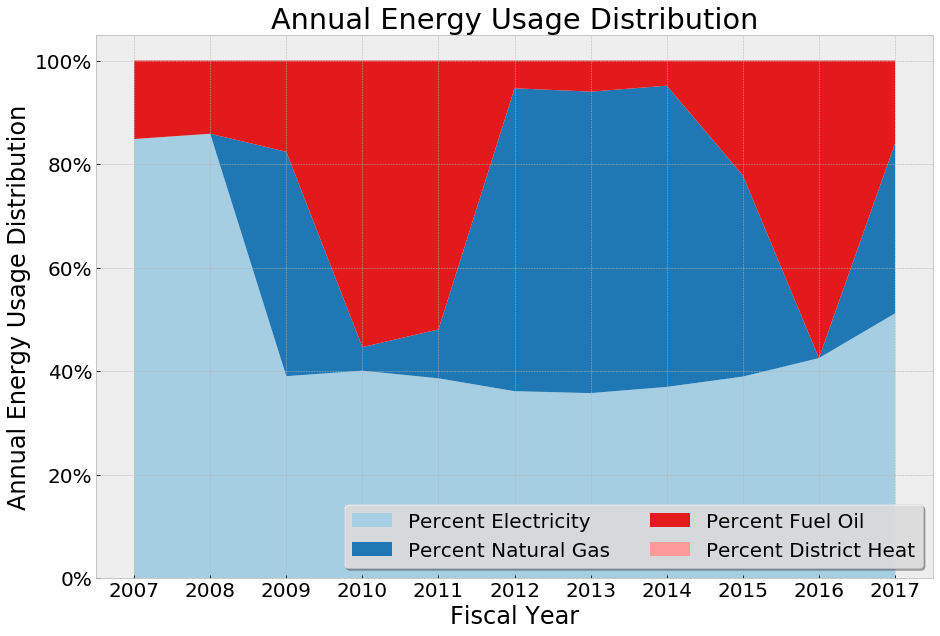

In [69]:
# Reset the index so the fiscal year column can be passed to the graphing function
reset_usage_df2 = usage_df2.reset_index()

p4g2_filename, p4g2_url = gu.graph_filename_url(site, 'annual_energy_usage_distribution')

# Create the area graph
gu.area_use_distribution(reset_usage_df2, 'fiscal_year', usage_cols, p4g2_filename)

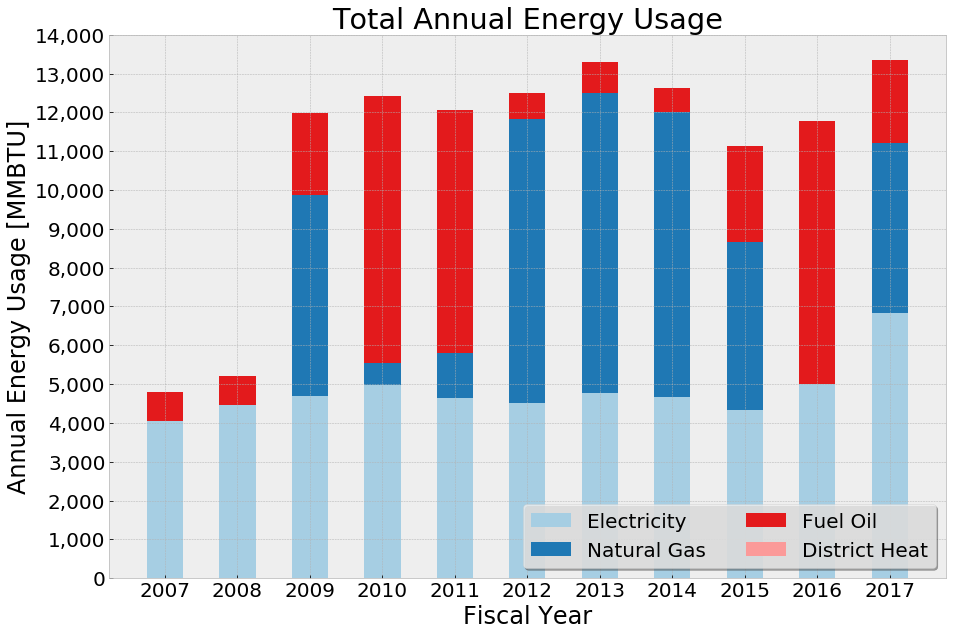

In [70]:
p4g1_filename, p4g1_url = gu.graph_filename_url(site, "annual_energy_usage")

gu.energy_use_stacked_bar(reset_usage_df2, 'fiscal_year', usage_cols, p4g1_filename)

In [71]:
# Convert df to dictionary
energy_use_overview_rows = bu.df_to_dictionaries(usage_df2)

# Add data and graphs to main dictionary
template_data['energy_usage_overview'] = dict(
    graphs=[p4g1_url, p4g2_url],
    table={'rows': energy_use_overview_rows},
)

# Create Usage Pie Charts

In [72]:
p5g1_filename, p5g1_url = gu.graph_filename_url(site, "energy_usage")
gu.usage_pie_charts(usage_df2, usage_cols, 1, p5g1_filename)

In [73]:
# Add pie charts to template dictionary
template_data['energy_cost_usage'] = dict(
    graphs=[p5g1_url])

# Electrical Usage Analysis - Page 6

In [74]:
site_df = df.query("site_id == @site")
site_df.head()

,site_id,service_type,cal_year,cal_mo,item_desc,units,cost,days_served,usage,fiscal_year,fiscal_mo,mmbtu
48636,DIPMP1,Electricity,2006,6,Energy charge,kWh,1971.105,16.5,24960.0,2006,12,85.16352
48637,DIPMP1,Electricity,2006,6,KW Charge,kW,931.745,16.5,117.0,2006,12,0.00000
48638,DIPMP1,Electricity,2006,6,Other Charge,-,621.220,16.5,NaN,2006,12,NaN
48639,DIPMP1,Electricity,2006,7,Energy charge,kWh,3736.435,31.0,47100.0,2007,1,160.70520
48640,DIPMP1,Electricity,2006,7,KW Charge,kW,1863.490,31.0,234.0,2007,1,0.00000


In [75]:
# only look at elecricity records
electric_df = site_df.query("service_type == 'Electricity'")

In [76]:
# Make sure I'm not potentially missing anything with funky unit names
check_df = electric_df.query("usage > 0")
check_df.units.unique()

array(['kWh', 'kW', 'kVAR'], dtype=object)

In [77]:
electric_df = electric_df.query("units == 'kWh' or units == 'kW'")
electric_df.head()

,site_id,service_type,cal_year,cal_mo,item_desc,units,cost,days_served,usage,fiscal_year,fiscal_mo,mmbtu
48636,DIPMP1,Electricity,2006,6,Energy charge,kWh,1971.105000,16.5,24960.000000,2006,12,85.163520
48637,DIPMP1,Electricity,2006,6,KW Charge,kW,931.745000,16.5,117.000000,2006,12,0.000000
48639,DIPMP1,Electricity,2006,7,Energy charge,kWh,3736.435000,31.0,47100.000000,2007,1,160.705200
48640,DIPMP1,Electricity,2006,7,KW Charge,kW,1863.490000,31.0,234.000000,2007,1,0.000000
48642,DIPMP1,Electricity,2006,8,Energy charge,kWh,3476.768548,31.0,43409.032258,2007,2,148.111618


In [78]:
electric_df.query("units == 'kWh'")['item_desc'].unique()

array(['Energy charge', 'Utility Charge'], dtype=object)

In [79]:
electric_df.item_desc.unique()

array(['Energy charge', 'KW Charge', 'On peak demand', 'Demand Charge',
       'Utility Charge', 'Actual demand'], dtype=object)

In [80]:
electric_pivot_monthly = pd.pivot_table(electric_df,
                                        index=['fiscal_year', 'fiscal_mo'], 
                                        columns=['units'],
                                        values='usage',
                                        aggfunc=np.sum)

electric_pivot_monthly.head()

units                          kW            kWh
fiscal_year fiscal_mo                           
2006        12         117.000000   24960.000000
2007        1          234.000000   47100.000000
            2          241.548387   43409.032258
            3          287.701613   54695.253456
            4          320.078125  107151.964286

In [81]:
# Do a month count for the elecricity bills 
elec_months_present = bu.months_present(electric_pivot_monthly.reset_index())
elec_mo_count = bu.month_count(elec_months_present)
elec_mo_count_df = pd.DataFrame(elec_mo_count)
elec_mo_count_df

,month
year,
2006,1
2007,12
2008,12
2009,12
2010,12
2011,12
2012,12
2013,12
2014,12


In [82]:
electric_pivot_annual = pd.pivot_table(electric_df,
                                       index=['fiscal_year'],
                                       columns=['units'],
                                       values='usage',
                                       aggfunc=np.sum
                                      )
                                       
electric_use_annual = electric_pivot_annual[['kWh']]
electric_use_annual = electric_use_annual.rename(columns={'kWh':'ann_electric_usage_kWh'})
electric_use_annual

units,ann_electric_usage_kWh
fiscal_year,
2006,2.496000e+04
2007,1.190794e+06
2008,1.311796e+06
2009,1.372648e+06
2010,1.460860e+06
2011,1.364646e+06
2012,1.323577e+06
2013,1.395143e+06
2014,1.367311e+06


In [83]:
# Get average annual demand usage
electric_demand_avg = electric_pivot_monthly.groupby(['fiscal_year']).mean()
electric_demand_avg = electric_demand_avg[['kW']]
electric_demand_avg = electric_demand_avg.rename(columns={'kW': 'avg_demand_kW'})
electric_demand_avg

units,avg_demand_kW
fiscal_year,
2006,117.000000
2007,270.565104
2008,247.520313
2009,261.967202
2010,292.492273
2011,301.101613
2012,265.742687
2013,278.553146
2014,249.558703


In [84]:
# Find annual maximum demand usage
electric_demand_max = electric_pivot_monthly.groupby(['fiscal_year']).max()
electric_demand_max = electric_demand_max[['kW']]
electric_demand_max = electric_demand_max.rename(columns={'kW': 'max_demand_kW'})
electric_demand_max

units,max_demand_kW
fiscal_year,
2006,117.000000
2007,320.078125
2008,321.336000
2009,281.265517
2010,330.574138
2011,430.021119
2012,287.280311
2013,303.987857
2014,294.672414


In [85]:
# Combine dataframes
electric_demand_join = pd.merge(electric_demand_max, electric_demand_avg, how='outer', left_index=True, right_index=True)
annual_electric_data = pd.merge(electric_demand_join, electric_use_annual, how='outer', left_index=True, right_index=True)
annual_electric_data

units,max_demand_kW,avg_demand_kW,ann_electric_usage_kWh
fiscal_year,,,
2006,117.000000,117.000000,2.496000e+04
2007,320.078125,270.565104,1.190794e+06
2008,321.336000,247.520313,1.311796e+06
2009,281.265517,261.967202,1.372648e+06
2010,330.574138,292.492273,1.460860e+06
2011,430.021119,301.101613,1.364646e+06
2012,287.280311,265.742687,1.323577e+06
2013,303.987857,278.553146,1.395143e+06
2014,294.672414,249.558703,1.367311e+06


In [86]:
# Add percent change columns
annual_electric_data['usage_pct_change'] = annual_electric_data.ann_electric_usage_kWh.pct_change()
annual_electric_data['avg_demand_pct_change'] = annual_electric_data.avg_demand_kW.pct_change()
annual_electric_data['max_demand_pct_change'] = annual_electric_data.max_demand_kW.pct_change()
annual_electric_data = annual_electric_data.rename(columns={'avg_demand_kW': 'Average kW',
                                                           'ann_electric_usage_kWh': 'Total kWh'})
annual_electric_data = pd.merge(annual_electric_data, elec_mo_count_df, left_index=True, right_index=True, how='left')
annual_electric_data = annual_electric_data.query("month == 12")
annual_electric_data = annual_electric_data.sort_index(ascending=False)
annual_electric_data = annual_electric_data.rename(columns={'max_demand_kW':'kw_max',
                                                           'Average kW':'kw_avg',
                                                           'Total kWh':'kwh',
                                                           'usage_pct_change':'kwh_pct_change',
                                                           'avg_demand_pct_change':'kw_avg_pct_change',
                                                           'max_demand_pct_change':'kw_max_pct_change'})
annual_electric_data = annual_electric_data.drop('month', axis=1)
annual_electric_data

,kw_max,kw_avg,kwh,kwh_pct_change,kw_avg_pct_change,kw_max_pct_change
fiscal_year,,,,,,
2017,569.872970,390.847177,2.002383e+06,0.364984,0.417757,0.936318
2016,294.307489,275.680036,1.466965e+06,0.153354,0.072229,0.023439
2015,287.567186,257.109245,1.271912e+06,-0.069771,0.030256,-0.024112
2014,294.672414,249.558703,1.367311e+06,-0.019950,-0.104089,-0.030644
2013,303.987857,278.553146,1.395143e+06,0.054071,0.048206,0.058158
2012,287.280311,265.742687,1.323577e+06,-0.030095,-0.117432,-0.331939
2011,430.021119,301.101613,1.364646e+06,-0.065862,0.029434,0.300831
2010,330.574138,292.492273,1.460860e+06,0.064264,0.116522,0.175310
2009,281.265517,261.967202,1.372648e+06,0.046388,0.058366,-0.124700


## Create Electrical Usage Analysis Graphs - Page 6

In [87]:
# Axes labels
ylabel1 = 'Electricity Usage [kWh]'
ylabel2 = 'Electricity Demand [kW]'

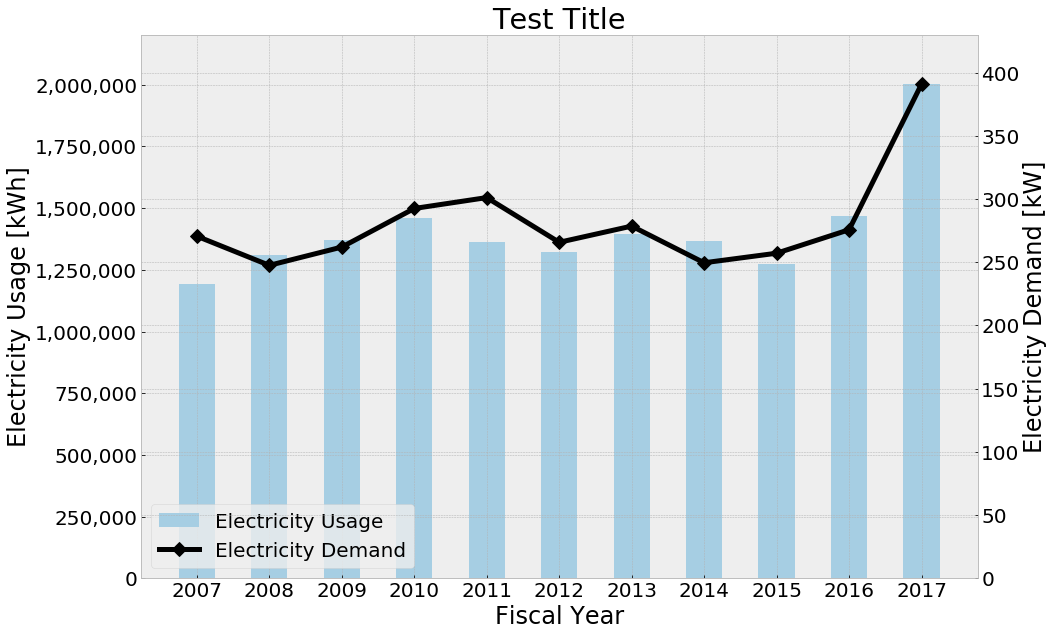

In [90]:
p6g1_filename, p6g1_url = gu.graph_filename_url(site, "electricity_usage")
gu.stacked_bar_with_line(annual_electric_data.reset_index(), 'fiscal_year', ['kwh'], 'kw_avg', 
                      ylabel1, ylabel2, "Test Title", p6g1_filename)

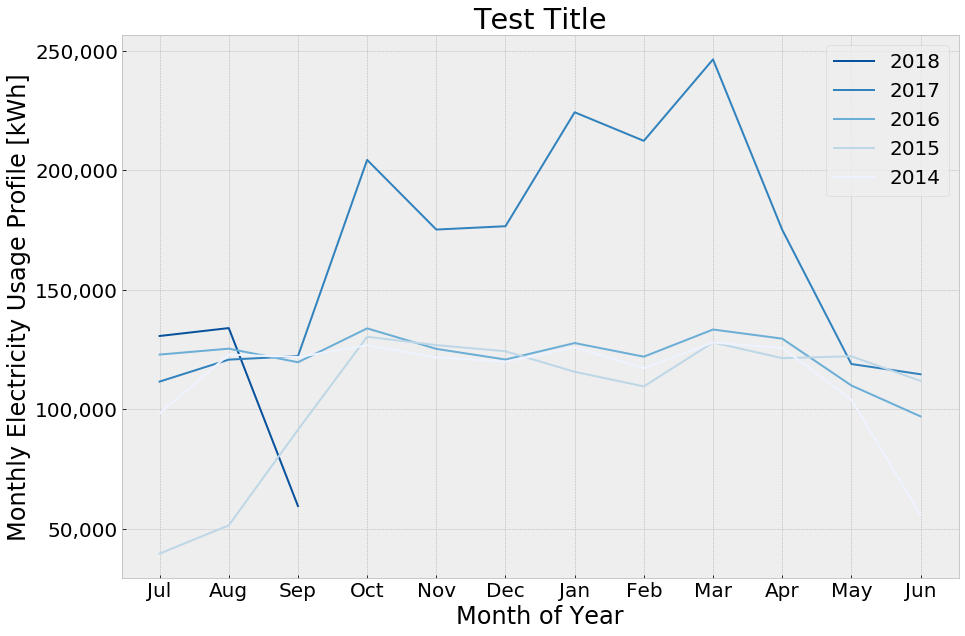

In [92]:
p6g2_filename, p6g2_url = gu.graph_filename_url(site, "monthly_electricity_usage_profile")
gu.create_monthly_profile(electric_pivot_monthly, 'kWh', 'Monthly Electricity Usage Profile [kWh]', 'blue',
                         "Test Title", p6g2_filename)

In [93]:
# Convert df to dictionary
electric_use_rows = bu.df_to_dictionaries(annual_electric_data)

# Add data and graphs to main dictionary
template_data['electrical_usage_analysis'] = dict(
    graphs=[p6g1_url, p6g2_url],
    table={'rows': electric_use_rows},
)

## Electrical Cost Analysis Table - Page 7

In [94]:
# only look at elecricity records
electric_cost_df = site_df.query("service_type == 'Electricity'")

In [95]:
electric_cost_df.item_desc.unique()

array(['Energy charge', 'KW Charge', 'Other Charge', 'On peak demand',
       'Demand Charge', 'Utility Charge', 'kVAR', 'Actual demand'], dtype=object)

In [96]:
# Costs don't always have units, so split the data into demand charges and usage charges (which includes other charges)
electric_cost_df['cost_categories'] = np.where(electric_cost_df.item_desc.isin(['KW Charge', 'On peak demand', 'Demand Charge']),
                                               'demand_cost', 'usage_cost')

C:\Anaconda2\envs\py35\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [97]:
# Sum costs by demand and usage
electric_annual_cost = pd.pivot_table(electric_cost_df,
                                       index=['fiscal_year'],
                                       columns=['cost_categories'],
                                       values='cost',
                                       aggfunc=np.sum
                                      )
# Create a total column
electric_annual_cost['Total Cost'] = electric_annual_cost.demand_cost + electric_annual_cost.usage_cost

electric_annual_cost

cost_categories,demand_cost,usage_cost,Total Cost
fiscal_year,,,
2006,931.745000,2592.325000,3524.070000
2007,26008.199375,124952.422656,150960.622031
2008,27417.794062,185717.228125,213135.022187
2009,27322.788420,173232.085076,200554.873496
2010,30406.295240,202389.183336,232795.478576
2011,32772.982097,195928.582097,228701.564194
2012,34696.867525,225266.682772,259963.550297
2013,38146.446023,236993.286421,275139.732445
2014,39515.007883,211917.016079,251432.023962


In [98]:
# Add percent change columns
electric_annual_cost['usage_cost_pct_change'] = electric_annual_cost.usage_cost.pct_change()
electric_annual_cost['demand_cost_pct_change'] = electric_annual_cost.demand_cost.pct_change()
electric_annual_cost['total_cost_pct_change'] = electric_annual_cost['Total Cost'].pct_change()
electric_annual_cost

cost_categories,demand_cost,usage_cost,Total Cost,usage_cost_pct_change,demand_cost_pct_change,total_cost_pct_change
fiscal_year,,,,,,
2006,931.745000,2592.325000,3524.070000,NaN,NaN,NaN
2007,26008.199375,124952.422656,150960.622031,47.200909,26.913431,41.837010
2008,27417.794062,185717.228125,213135.022187,0.486304,0.054198,0.411858
2009,27322.788420,173232.085076,200554.873496,-0.067227,-0.003465,-0.059024
2010,30406.295240,202389.183336,232795.478576,0.168312,0.112855,0.160757
2011,32772.982097,195928.582097,228701.564194,-0.031922,0.077835,-0.017586
2012,34696.867525,225266.682772,259963.550297,0.149739,0.058703,0.136693
2013,38146.446023,236993.286421,275139.732445,0.052057,0.099420,0.058378
2014,39515.007883,211917.016079,251432.023962,-0.105810,0.035877,-0.086166


In [99]:
# Left join the cost data to the annual electric data, which only shows complete years
electric_use_and_cost = pd.merge(annual_electric_data, electric_annual_cost, left_index=True, right_index=True, how='left')
electric_use_and_cost = electric_use_and_cost.sort_index(ascending=False)
electric_use_and_cost = electric_use_and_cost.drop(['kw_max', 'kw_max_pct_change'], axis=1)
electric_use_and_cost = electric_use_and_cost.rename(columns={'demand_cost':'kw_avg_cost',
                                                              'usage_cost':'kwh_cost',
                                                              'Total Cost':'total_cost',
                                                              'usage_cost_pct_change':'kwh_cost_pct_change',
                                                              'demand_cost_pct_change':'kw_avg_cost_pct_change'
                                                             })
electric_use_and_cost


,kw_avg,kwh,kwh_pct_change,kw_avg_pct_change,kw_avg_cost,kwh_cost,total_cost,kwh_cost_pct_change,kw_avg_cost_pct_change,total_cost_pct_change
fiscal_year,,,,,,,,,,
2017,390.847177,2.002383e+06,0.364984,0.417757,47738.260484,358553.796129,406292.056613,0.797092,0.047793,0.657796
2016,275.680036,1.466965e+06,0.153354,0.072229,45560.764985,199518.886683,245079.651668,0.066822,0.135625,0.078975
2015,257.109245,1.271912e+06,-0.069771,0.030256,40119.548906,187021.650625,227141.199531,-0.117477,0.015299,-0.096610
2014,249.558703,1.367311e+06,-0.019950,-0.104089,39515.007883,211917.016079,251432.023962,-0.105810,0.035877,-0.086166
2013,278.553146,1.395143e+06,0.054071,0.048206,38146.446023,236993.286421,275139.732445,0.052057,0.099420,0.058378
2012,265.742687,1.323577e+06,-0.030095,-0.117432,34696.867525,225266.682772,259963.550297,0.149739,0.058703,0.136693
2011,301.101613,1.364646e+06,-0.065862,0.029434,32772.982097,195928.582097,228701.564194,-0.031922,0.077835,-0.017586
2010,292.492273,1.460860e+06,0.064264,0.116522,30406.295240,202389.183336,232795.478576,0.168312,0.112855,0.160757
2009,261.967202,1.372648e+06,0.046388,0.058366,27322.788420,173232.085076,200554.873496,-0.067227,-0.003465,-0.059024


## Create Electrical Cost Analysis Graphs - Page 7

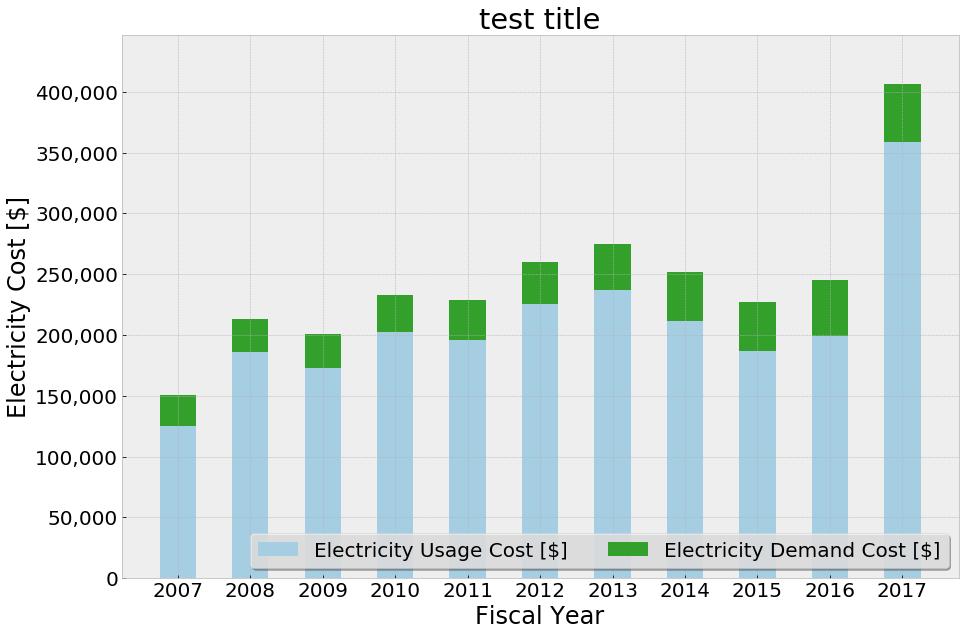

In [102]:
p7g1_filename, p7g1_url = gu.graph_filename_url(site, "electricity_cost")

renamed_use_and_cost = electric_use_and_cost.rename(columns={'kwh_cost':'Electricity Usage Cost [$]',
                                                            'kw_avg_cost':'Electricity Demand Cost [$]'})
gu.create_stacked_bar(renamed_use_and_cost.reset_index(), 'fiscal_year', ['Electricity Usage Cost [$]', 
                                                                          'Electricity Demand Cost [$]'], 
                      'Electricity Cost [$]', "test title", p7g1_filename)

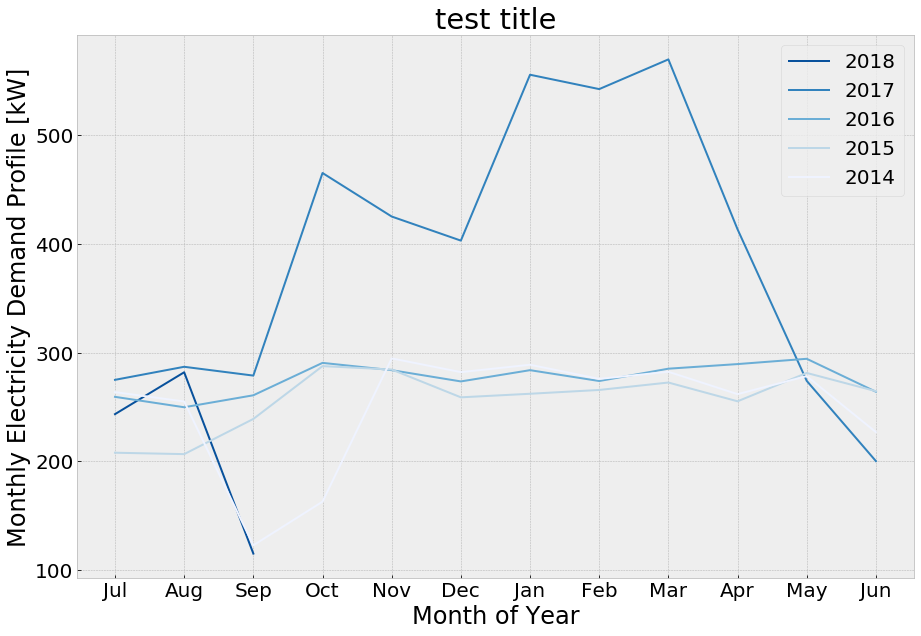

In [103]:
# Create Monthly Profile of Electricity Demand
p7g2_filename, p7g2_url = gu.graph_filename_url(site, "monthly_electricity_demand_profile")
gu.create_monthly_profile(electric_pivot_monthly, 'kW', 'Monthly Electricity Demand Profile [kW]', 'blue', 
                          "test title", p7g2_filename)

In [104]:
# Convert df to dictionary
electric_cost_rows = bu.df_to_dictionaries(electric_use_and_cost)

# Add data and graphs to main dictionary
template_data['electrical_cost_analysis'] = dict(
    graphs=[p7g1_url, p7g2_url],
    table={'rows': electric_cost_rows},
)

# Create Heating Usage Analysis Table - Page 8

In [105]:
usage_df2.head()

,electricity_mmbtu,natural_gas_mmbtu,fuel_oil_mmbtu,district_heat_mmbtu,total_energy_mmbtu,electricity_pct,natural_gas_pct,fuel_oil_pct,district_heat_pct,hdd,total_heat_mmbtu,total_specific_heat
fiscal_year,,,,,,,,,,,,
2017,6832.131566,4379.715484,2137.725000,0.0,13349.572050,0.511787,0.328079,0.160134,0.0,13802,6517.440484,472.209860
2016,5005.284236,0.000000,6761.947500,0.0,11767.231736,0.425358,0.000000,0.574642,0.0,12017,6761.947500,562.698469
2015,4339.763318,4328.011355,2470.153986,0.0,11137.928659,0.389638,0.388583,0.221779,0.0,12345,6798.165341,550.681680
2014,4665.265022,7340.779372,612.212365,0.0,12618.256760,0.369723,0.581759,0.048518,0.0,12531,7952.991738,634.665369
2013,4760.229306,7748.241853,798.431211,0.0,13306.902370,0.357726,0.582272,0.060001,0.0,14939,8546.673064,572.104764


In [106]:
# Take only needed columns from earlier usage df
heating_usage = usage_df2[['natural_gas_mmbtu', 'fuel_oil_mmbtu', 'district_heat_mmbtu', 'hdd', 'total_heat_mmbtu']]
heating_usage

,natural_gas_mmbtu,fuel_oil_mmbtu,district_heat_mmbtu,hdd,total_heat_mmbtu
fiscal_year,,,,,
2017,4379.715484,2137.725000,0.0,13802,6517.440484
2016,0.000000,6761.947500,0.0,12017,6761.947500
2015,4328.011355,2470.153986,0.0,12345,6798.165341
2014,7340.779372,612.212365,0.0,12531,7952.991738
2013,7748.241853,798.431211,0.0,14939,8546.673064
2012,7309.068619,668.293467,0.0,13960,7977.362086
2011,1139.153000,6259.229880,0.0,13667,7398.382880
2010,566.276800,6879.015877,0.0,13119,7445.292677
2009,5199.297000,2112.606964,0.0,14471,7311.903964


In [107]:
# Add in percent change columns
heating_usage['fuel_oil_pct_change'] = heating_usage.fuel_oil_mmbtu.pct_change()
heating_usage['natural_gas_pct_change'] = heating_usage.natural_gas_mmbtu.pct_change()
heating_usage['district_heat_pct_change'] = heating_usage.district_heat_mmbtu.pct_change()
heating_usage['total_heat_pct_change'] = heating_usage.total_heat_mmbtu.pct_change()
heating_usage

C:\Anaconda2\envs\py35\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Anaconda2\envs\py35\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Anaconda2\envs\py35\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

,natural_gas_mmbtu,fuel_oil_mmbtu,district_heat_mmbtu,hdd,total_heat_mmbtu,fuel_oil_pct_change,natural_gas_pct_change,district_heat_pct_change,total_heat_pct_change
fiscal_year,,,,,,,,,
2017,4379.715484,2137.725000,0.0,13802,6517.440484,NaN,NaN,NaN,NaN
2016,0.000000,6761.947500,0.0,12017,6761.947500,2.163151,-1.000000,NaN,0.037516
2015,4328.011355,2470.153986,0.0,12345,6798.165341,-0.634698,inf,NaN,0.005356
2014,7340.779372,612.212365,0.0,12531,7952.991738,-0.752156,0.696109,NaN,0.169873
2013,7748.241853,798.431211,0.0,14939,8546.673064,0.304174,0.055507,NaN,0.074649
2012,7309.068619,668.293467,0.0,13960,7977.362086,-0.162992,-0.056680,NaN,-0.066612
2011,1139.153000,6259.229880,0.0,13667,7398.382880,8.365990,-0.844145,NaN,-0.072578
2010,566.276800,6879.015877,0.0,13119,7445.292677,0.099020,-0.502897,NaN,0.006341
2009,5199.297000,2112.606964,0.0,14471,7311.903964,-0.692891,8.181547,NaN,-0.017916


In [108]:
# Get the number of gallons, ccf, and 1,000 pounds of district heat by converting MMBTUs using the supplied conversions
heating_usage['fuel_oil_usage'] = heating_usage.fuel_oil_mmbtu * 1000000 / ut.fuel_btus_per_unit('Oil #1', 'gallons')
heating_usage['natural_gas_usage'] = heating_usage.natural_gas_mmbtu * 1000000 / ut.fuel_btus_per_unit('Natural Gas', 'ccf')
heating_usage

C:\Anaconda2\envs\py35\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Anaconda2\envs\py35\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,natural_gas_mmbtu,fuel_oil_mmbtu,district_heat_mmbtu,hdd,total_heat_mmbtu,fuel_oil_pct_change,natural_gas_pct_change,district_heat_pct_change,total_heat_pct_change,fuel_oil_usage,natural_gas_usage
fiscal_year,,,,,,,,,,,
2017,4379.715484,2137.725000,0.0,13802,6517.440484,NaN,NaN,NaN,NaN,15835.000000,42938.387097
2016,0.000000,6761.947500,0.0,12017,6761.947500,2.163151,-1.000000,NaN,0.037516,50088.500000,0.000000
2015,4328.011355,2470.153986,0.0,12345,6798.165341,-0.634698,inf,NaN,0.005356,18297.436937,42431.483871
2014,7340.779372,612.212365,0.0,12531,7952.991738,-0.752156,0.696109,NaN,0.169873,4534.906411,71968.425220
2013,7748.241853,798.431211,0.0,14939,8546.673064,0.304174,0.055507,NaN,0.074649,5914.305263,75963.155425
2012,7309.068619,668.293467,0.0,13960,7977.362086,-0.162992,-0.056680,NaN,-0.066612,4950.321977,71657.535484
2011,1139.153000,6259.229880,0.0,13667,7398.382880,8.365990,-0.844145,NaN,-0.072578,46364.665775,11168.166667
2010,566.276800,6879.015877,0.0,13119,7445.292677,0.099020,-0.502897,NaN,0.006341,50955.673160,5551.733333
2009,5199.297000,2112.606964,0.0,14471,7311.903964,-0.692891,8.181547,NaN,-0.017916,15648.940476,50973.500000


## Create Heating Usage Analysis Graphs - Page 8

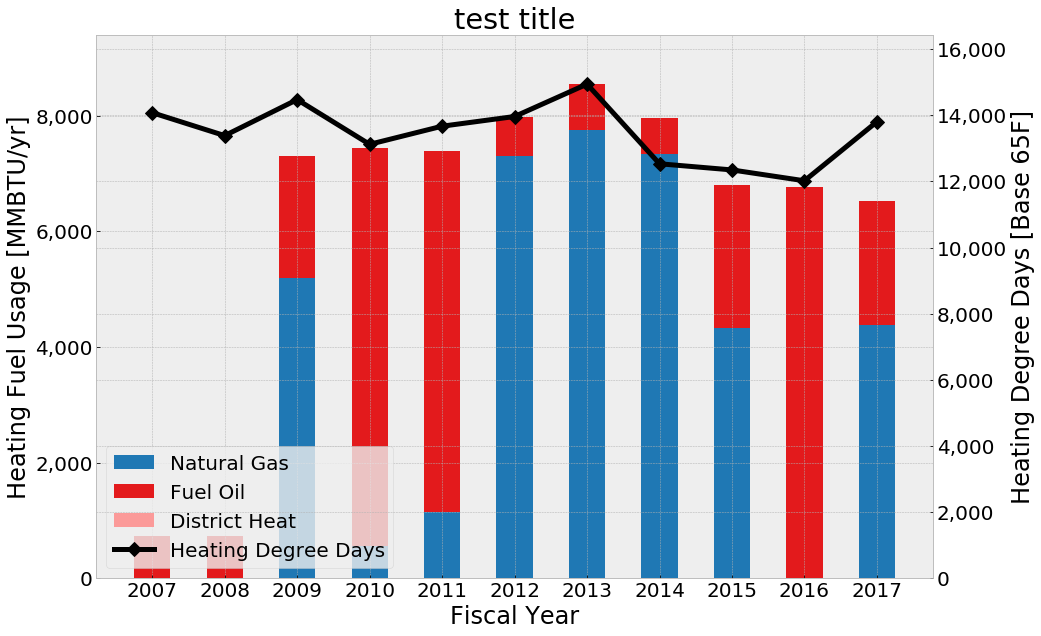

In [110]:
p8g1_filename, p8g1_url = gu.graph_filename_url(site, "heating_degree_days")
gu.stacked_bar_with_line(heating_usage.reset_index(), 'fiscal_year', ['natural_gas_mmbtu', 'fuel_oil_mmbtu',
                                                                                'district_heat_mmbtu'], 'hdd',
                        'Heating Fuel Usage [MMBTU/yr]', 'Heating Degree Days [Base 65F]', "test title", p8g1_filename)

### Create Monthly Heating Usage dataframe for graph

In [111]:
monthly_heating = pd.pivot_table(usage_df1,
                                values='mmbtu',
                                index=['fiscal_year', 'fiscal_mo'],
                                columns=['service_type'],
                                aggfunc=np.sum
                                )
monthly_heating.head()

service_type           Electricity  Natural Gas     Oil #1  Sewer  Water
fiscal_year fiscal_mo                                                   
2006        9                  NaN          NaN   6.373421    NaN    NaN
            10                 NaN          NaN  16.626316    NaN    NaN
            11                 NaN          NaN  17.180526    NaN    NaN
            12            85.16352          NaN  16.626316    NaN    NaN
2007        1            160.70520          NaN  17.180526    NaN    NaN

In [112]:
monthly_heating

service_type           Electricity  Natural Gas      Oil #1  Sewer  Water
fiscal_year fiscal_mo                                                    
2006        9                  NaN          NaN    6.373421    NaN    NaN
            10                 NaN          NaN   16.626316    NaN    NaN
            11                 NaN          NaN   17.180526    NaN    NaN
            12           85.163520          NaN   16.626316    NaN    NaN
2007        1           160.705200          NaN   17.180526    NaN    NaN
            2           148.111618          NaN   17.180526    NaN    NaN
            3           186.620205          NaN   54.112846    NaN    NaN
            4           365.602502          NaN   66.630843    0.0    0.0
            5           408.654387          NaN   64.481461    0.0    0.0
            6           402.043210          NaN   73.236728    0.0    0.0
            7           424.390958          NaN   75.378912    0.0    0.0
            8           371.142737          NaN   86.210526    0.0    0.0
            9           400.208103          NaN   91.583933    0.0    0.0
            10          408.542974          NaN   59.253261    0.0    0.0
            11          405.451468          NaN   61.228370    0.0    0.0
            12          381.514912          NaN   58.802705    0.0    0.0
2008        1           212.853355          NaN   55.641477    0.0    0.0
            2           230.574430          NaN   55.641477    0.0    0.0
            3           415.163971          NaN   55.122955    0.0    0.0
            4           449.666363          NaN   81.403038    0.0    0.0
            5           439.320777          NaN   87.969767    0.0    0.0
            6           403.914699          NaN   82.941070    0.0    0.0
            7           374.386973          NaN   77.516710    0.0    0.0
            8           384.190259          NaN   66.670632    0.0    0.0
            9           434.846913          NaN   56.076343    0.0    0.0
            10          404.492380          NaN   33.287671    0.0    0.0
            11          398.801384          NaN   34.397260    0.0    0.0
            12          327.637300          NaN   49.758134    0.0    0.0
2009        1           319.578156          NaN   52.312500    0.0    0.0
            2           372.932027    53.842091   52.312500    0.0    0.0
...                            ...          ...         ...    ...    ...
2015        10          414.053450     0.000000  498.858312    0.0    0.0
            11          416.682146     0.000000  323.552045    0.0    0.0
            12          381.513883     0.000000  198.450000    0.0    0.0
2016        1           419.162205     0.000000  307.415543    0.0    0.0
            2           427.578907     0.000000  324.890707    0.0    0.0
            3           408.168442     0.000000  403.380000    0.0    0.0
            4           456.565995     0.000000  610.098750    0.0    0.0
            5           427.290630     0.000000  848.390625    0.0    0.0
            6           412.070611     0.000000  948.459375    0.0    0.0
            7           435.612172     0.000000  794.880000    0.0    0.0
            8           416.148845     0.000000  775.110937    0.0    0.0
            9           454.948403     0.000000  701.620312    0.0    0.0
            10          441.933300     0.000000  439.661250    0.0    0.0
            11          374.986080     0.000000  413.398929    0.0    0.0
            12          330.818646     0.000000  194.641071    0.0    0.0
2017        1           380.544055     0.000000  201.594569    0.0    0.0
            2           411.922015     0.000000  317.755252    0.0    0.0
            3           416.903629     0.000000  441.310179    0.0    0.0
            4           697.308732     0.000000  718.210385    0.0    0.0
            5           597.780578    12.926032  458.854615    0.0    0.0
            6           602.563353   805.859226         NaN    0.0    0.0
    

In [113]:
# Add in columns for the missing energy services
missing_services = bu.missing_energy_services(monthly_heating.columns)
bu.add_columns(monthly_heating, missing_services)

# Drop the non-heating services
monthly_heating = monthly_heating.drop(labels=['Electricity', 'Sewer', 'Water'], axis=1)

# Create a total heating column
monthly_heating['total_heating_energy'] = monthly_heating.sum(axis=1)

monthly_heating.head()

service_type           Natural Gas     Oil #1  Steam  total_heating_energy
fiscal_year fiscal_mo                                                     
2006        9                  NaN   6.373421    0.0              6.373421
            10                 NaN  16.626316    0.0             16.626316
            11                 NaN  17.180526    0.0             17.180526
            12                 NaN  16.626316    0.0             16.626316
2007        1                  NaN  17.180526    0.0             17.180526

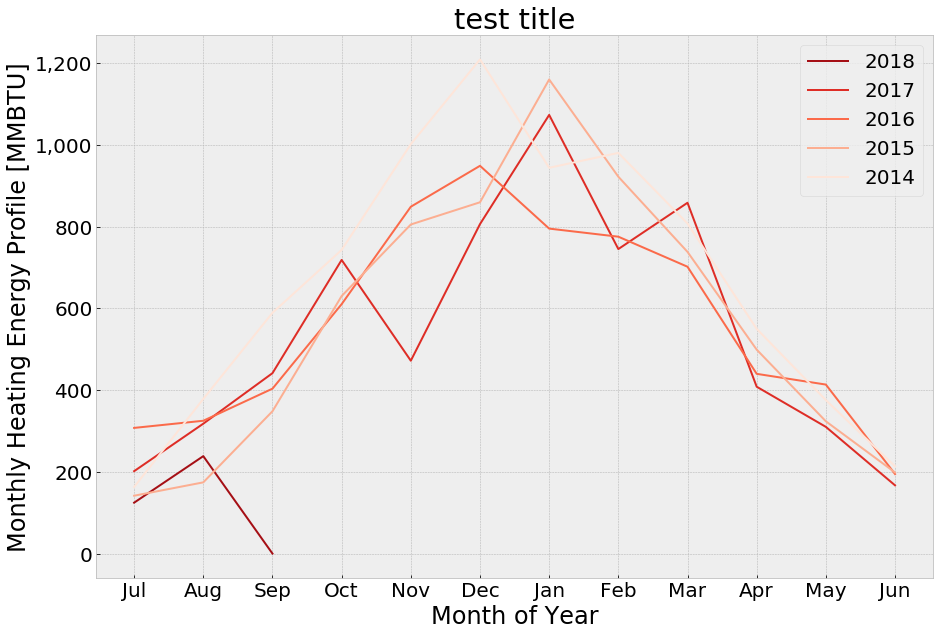

In [116]:
p8g2_filename, p8g2_url = gu.graph_filename_url(site, "monthly_heating_energy_profile")
gu.create_monthly_profile(monthly_heating, 'total_heating_energy', "Monthly Heating Energy Profile [MMBTU]", 'red',
                          "test title", p8g2_filename)

In [117]:
# Convert df to dictionary
heating_use_rows = bu.df_to_dictionaries(heating_usage)

# Add data and graphs to main dictionary
template_data['heating_usage_analysis'] = dict(
    graphs=[p8g1_url, p8g2_url],
    table={'rows': heating_use_rows},
)

## Heating Cost Analysis Table - Page 9

In [118]:
# Import df that I exported from "alan_report_pages".  This can be removed once code is combined
df2 = pd.read_csv(r"C:\Users\dustin\Google Drive\FNSB Data Analysis\data_from_alan_report_pages_df2.csv")

# Use only necessary columns
heating_cost = df2[['fiscal_year', 'Natural Gas', 'Oil #1', 'Steam', 'Total', 'pct_change']]

# Change column names so they aren't the same as the heating usage dataframe
heating_cost = heating_cost.rename(columns={'Natural Gas':'natural_gas_cost',
                                           'Oil #1': 'fuel_oil_cost',
                                           'Steam': 'district_heat_cost',
                                           'Total': 'total_heat_cost',
                                           'pct_change': 'total_heat_cost_pct_change'})
heating_cost

,fiscal_year,natural_gas_cost,fuel_oil_cost,district_heat_cost,total_heat_cost,total_heat_cost_pct_change
0,2017,53336.961562,29028.075000,0.0,294496.131925,-0.211853
1,2016,690.478276,90349.225000,0.0,373656.286356,-0.090911
2,2015,97125.406774,48709.171396,0.0,411022.962057,-0.127236
3,2014,164359.650963,15747.134827,0.0,470943.816735,-0.073340
4,2013,173104.449037,20369.326596,0.0,508216.253007,0.048115
5,2012,163613.406387,17351.334533,0.0,484885.747289,0.157875
6,2011,20902.767000,139185.262647,0.0,418772.262631,NaN


In [119]:
heating_usage

,natural_gas_mmbtu,fuel_oil_mmbtu,district_heat_mmbtu,hdd,total_heat_mmbtu,fuel_oil_pct_change,natural_gas_pct_change,district_heat_pct_change,total_heat_pct_change,fuel_oil_usage,natural_gas_usage
fiscal_year,,,,,,,,,,,
2017,4379.715484,2137.725000,0.0,13802,6517.440484,NaN,NaN,NaN,NaN,15835.000000,42938.387097
2016,0.000000,6761.947500,0.0,12017,6761.947500,2.163151,-1.000000,NaN,0.037516,50088.500000,0.000000
2015,4328.011355,2470.153986,0.0,12345,6798.165341,-0.634698,inf,NaN,0.005356,18297.436937,42431.483871
2014,7340.779372,612.212365,0.0,12531,7952.991738,-0.752156,0.696109,NaN,0.169873,4534.906411,71968.425220
2013,7748.241853,798.431211,0.0,14939,8546.673064,0.304174,0.055507,NaN,0.074649,5914.305263,75963.155425
2012,7309.068619,668.293467,0.0,13960,7977.362086,-0.162992,-0.056680,NaN,-0.066612,4950.321977,71657.535484
2011,1139.153000,6259.229880,0.0,13667,7398.382880,8.365990,-0.844145,NaN,-0.072578,46364.665775,11168.166667
2010,566.276800,6879.015877,0.0,13119,7445.292677,0.099020,-0.502897,NaN,0.006341,50955.673160,5551.733333
2009,5199.297000,2112.606964,0.0,14471,7311.903964,-0.692891,8.181547,NaN,-0.017916,15648.940476,50973.500000


In [120]:
# Combine the heating cost and heating use dataframes
heating_cost_and_use = pd.merge(heating_cost, heating_usage, left_on='fiscal_year', right_index=True, how='right')
heating_cost_and_use

,fiscal_year,natural_gas_cost,fuel_oil_cost,district_heat_cost,total_heat_cost,total_heat_cost_pct_change,natural_gas_mmbtu,fuel_oil_mmbtu,district_heat_mmbtu,hdd,total_heat_mmbtu,fuel_oil_pct_change,natural_gas_pct_change,district_heat_pct_change,total_heat_pct_change,fuel_oil_usage,natural_gas_usage
0,2017,53336.961562,29028.075000,0.0,294496.131925,-0.211853,4379.715484,2137.725000,0.0,13802,6517.440484,NaN,NaN,NaN,NaN,15835.000000,42938.387097
1,2016,690.478276,90349.225000,0.0,373656.286356,-0.090911,0.000000,6761.947500,0.0,12017,6761.947500,2.163151,-1.000000,NaN,0.037516,50088.500000,0.000000
2,2015,97125.406774,48709.171396,0.0,411022.962057,-0.127236,4328.011355,2470.153986,0.0,12345,6798.165341,-0.634698,inf,NaN,0.005356,18297.436937,42431.483871
3,2014,164359.650963,15747.134827,0.0,470943.816735,-0.073340,7340.779372,612.212365,0.0,12531,7952.991738,-0.752156,0.696109,NaN,0.169873,4534.906411,71968.425220
4,2013,173104.449037,20369.326596,0.0,508216.253007,0.048115,7748.241853,798.431211,0.0,14939,8546.673064,0.304174,0.055507,NaN,0.074649,5914.305263,75963.155425
5,2012,163613.406387,17351.334533,0.0,484885.747289,0.157875,7309.068619,668.293467,0.0,13960,7977.362086,-0.162992,-0.056680,NaN,-0.066612,4950.321977,71657.535484
6,2011,20902.767000,139185.262647,0.0,418772.262631,NaN,1139.153000,6259.229880,0.0,13667,7398.382880,8.365990,-0.844145,NaN,-0.072578,46364.665775,11168.166667
6,2010,NaN,NaN,NaN,NaN,NaN,566.276800,6879.015877,0.0,13119,7445.292677,0.099020,-0.502897,NaN,0.006341,50955.673160,5551.733333
6,2009,NaN,NaN,NaN,NaN,NaN,5199.297000,2112.606964,0.0,14471,7311.903964,-0.692891,8.181547,NaN,-0.017916,15648.940476,50973.500000
6,2008,NaN,NaN,NaN,NaN,NaN,NaN,736.426534,0.0,13382,NaN,-0.651413,NaN,NaN,NaN,5455.011364,NaN


In [121]:
# Create percent change columns
heating_cost_and_use['fuel_oil_pct_change'] = heating_cost_and_use.fuel_oil_cost.pct_change()
heating_cost_and_use['natural_gas_pct_change'] = heating_cost_and_use.natural_gas_cost.pct_change()
heating_cost_and_use['district_heat_pct_change'] = heating_cost_and_use.district_heat_cost.pct_change()

In [122]:
# Create unit cost columns
heating_cost_and_use['fuel_oil_unit_cost'] = heating_cost_and_use.fuel_oil_cost / heating_cost_and_use.fuel_oil_mmbtu
heating_cost_and_use['natural_gas_unit_cost'] = heating_cost_and_use.natural_gas_cost / heating_cost_and_use.natural_gas_mmbtu
heating_cost_and_use['district_heat_unit_cost'] = heating_cost_and_use.district_heat_cost / heating_cost_and_use.district_heat_mmbtu
heating_cost_and_use['building_heat_unit_cost'] = heating_cost_and_use.total_heat_cost / heating_cost_and_use.total_heat_mmbtu
heating_cost_and_use

,fiscal_year,natural_gas_cost,fuel_oil_cost,district_heat_cost,total_heat_cost,total_heat_cost_pct_change,natural_gas_mmbtu,fuel_oil_mmbtu,district_heat_mmbtu,hdd,...,fuel_oil_pct_change,natural_gas_pct_change,district_heat_pct_change,total_heat_pct_change,fuel_oil_usage,natural_gas_usage,fuel_oil_unit_cost,natural_gas_unit_cost,district_heat_unit_cost,building_heat_unit_cost
0,2017,53336.961562,29028.075000,0.0,294496.131925,-0.211853,4379.715484,2137.725000,0.0,13802,...,NaN,NaN,NaN,NaN,15835.000000,42938.387097,13.578957,12.178180,NaN,45.185857
1,2016,690.478276,90349.225000,0.0,373656.286356,-0.090911,0.000000,6761.947500,0.0,12017,...,2.112477,-0.987054,NaN,0.037516,50088.500000,0.000000,13.361421,inf,NaN,55.258679
2,2015,97125.406774,48709.171396,0.0,411022.962057,-0.127236,4328.011355,2470.153986,0.0,12345,...,-0.460879,139.663957,NaN,0.005356,18297.436937,42431.483871,19.719083,22.441116,NaN,60.460866
3,2014,164359.650963,15747.134827,0.0,470943.816735,-0.073340,7340.779372,612.212365,0.0,12531,...,-0.676711,0.692242,NaN,0.169873,4534.906411,71968.425220,25.721687,22.389946,NaN,59.215932
4,2013,173104.449037,20369.326596,0.0,508216.253007,0.048115,7748.241853,798.431211,0.0,14939,...,0.293526,0.053205,NaN,0.074649,5914.305263,75963.155425,25.511686,22.341126,NaN,59.463636
5,2012,163613.406387,17351.334533,0.0,484885.747289,0.157875,7309.068619,668.293467,0.0,13960,...,-0.148164,-0.054828,NaN,-0.066612,4950.321977,71657.535484,25.963645,22.384987,NaN,60.782718
6,2011,20902.767000,139185.262647,0.0,418772.262631,NaN,1139.153000,6259.229880,0.0,13667,...,7.021588,-0.872243,NaN,-0.072578,46364.665775,11168.166667,22.236803,18.349394,NaN,56.603216
6,2010,NaN,NaN,NaN,NaN,NaN,566.276800,6879.015877,0.0,13119,...,NaN,NaN,NaN,0.006341,50955.673160,5551.733333,NaN,NaN,NaN,NaN
6,2009,NaN,NaN,NaN,NaN,NaN,5199.297000,2112.606964,0.0,14471,...,NaN,NaN,NaN,-0.017916,15648.940476,50973.500000,NaN,NaN,NaN,NaN
6,2008,NaN,NaN,NaN,NaN,NaN,NaN,736.426534,0.0,13382,...,NaN,NaN,NaN,NaN,5455.011364,NaN,NaN,NaN,NaN,NaN


In [123]:
# Remove all columns not needed for the Heating Cost Analysis Table
heating_cost_and_use = heating_cost_and_use[['fiscal_year',
                                              'fuel_oil_cost',
                                              'fuel_oil_pct_change',
                                              'natural_gas_cost',
                                              'natural_gas_pct_change',
                                              'district_heat_cost',
                                              'district_heat_pct_change',
                                              'fuel_oil_unit_cost',
                                              'natural_gas_unit_cost',
                                              'district_heat_unit_cost',
                                              'building_heat_unit_cost',
                                              'total_heat_cost',
                                              'total_heat_cost_pct_change']]

heating_cost_and_use

,fiscal_year,fuel_oil_cost,fuel_oil_pct_change,natural_gas_cost,natural_gas_pct_change,district_heat_cost,district_heat_pct_change,fuel_oil_unit_cost,natural_gas_unit_cost,district_heat_unit_cost,building_heat_unit_cost,total_heat_cost,total_heat_cost_pct_change
0,2017,29028.075000,NaN,53336.961562,NaN,0.0,NaN,13.578957,12.178180,NaN,45.185857,294496.131925,-0.211853
1,2016,90349.225000,2.112477,690.478276,-0.987054,0.0,NaN,13.361421,inf,NaN,55.258679,373656.286356,-0.090911
2,2015,48709.171396,-0.460879,97125.406774,139.663957,0.0,NaN,19.719083,22.441116,NaN,60.460866,411022.962057,-0.127236
3,2014,15747.134827,-0.676711,164359.650963,0.692242,0.0,NaN,25.721687,22.389946,NaN,59.215932,470943.816735,-0.073340
4,2013,20369.326596,0.293526,173104.449037,0.053205,0.0,NaN,25.511686,22.341126,NaN,59.463636,508216.253007,0.048115
5,2012,17351.334533,-0.148164,163613.406387,-0.054828,0.0,NaN,25.963645,22.384987,NaN,60.782718,484885.747289,0.157875
6,2011,139185.262647,7.021588,20902.767000,-0.872243,0.0,NaN,22.236803,18.349394,NaN,56.603216,418772.262631,NaN
6,2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Create DataFrame with the Monthly Average Price Per MMBTU for All Sites

In [124]:
print (df.shape[0])

# Filter out natural gas customer charges as the unit cost goes to infinity if there is a charge but no use
df_no_gas_cust_charges = df.drop(df[(df['service_type'] == 'Natural Gas') & (df['units'] != 'CCF')].index)

# Filter out records with zero usage, which correspond to things like customer charges, etc.
nonzero_usage = df_no_gas_cust_charges.query("usage > 0")
print (nonzero_usage.shape[0])
nonzero_usage.head()

74268
37607


,site_id,service_type,cal_year,cal_mo,item_desc,units,cost,days_served,usage,fiscal_year,fiscal_mo,mmbtu
0,03,Electricity,2005,12,Electricity charge,kWh,1904.657880,49.5,14790.748577,2006,6,50.466034
1,03,Electricity,2006,1,Electricity charge,kWh,5430.493797,93.0,42665.790911,2006,7,145.575679
2,03,Electricity,2006,2,Electricity charge,kWh,5764.406730,84.0,45010.439348,2006,8,153.575619
3,03,Electricity,2006,3,Electricity charge,kWh,6349.255299,93.0,46311.547557,2006,9,158.015000
4,03,Electricity,2006,4,Electricity charge,kWh,5529.385224,90.0,40392.812893,2006,10,137.820278


In [125]:
# Check to make sure it is okay to drop records w/ zero mmbtu
zero_mmbtu = nonzero_usage.query("mmbtu == 0")
zero_mmbtu.service_type.unique()

array(['Refuse', 'Water', 'Electricity', 'Sewer'], dtype=object)

In [126]:
nonzero_usage = nonzero_usage.query("mmbtu > 0")
print (nonzero_usage.shape[0])
nonzero_usage.head()

21159


,site_id,service_type,cal_year,cal_mo,item_desc,units,cost,days_served,usage,fiscal_year,fiscal_mo,mmbtu
0,03,Electricity,2005,12,Electricity charge,kWh,1904.657880,49.5,14790.748577,2006,6,50.466034
1,03,Electricity,2006,1,Electricity charge,kWh,5430.493797,93.0,42665.790911,2006,7,145.575679
2,03,Electricity,2006,2,Electricity charge,kWh,5764.406730,84.0,45010.439348,2006,8,153.575619
3,03,Electricity,2006,3,Electricity charge,kWh,6349.255299,93.0,46311.547557,2006,9,158.015000
4,03,Electricity,2006,4,Electricity charge,kWh,5529.385224,90.0,40392.812893,2006,10,137.820278


In [127]:
nonzero_usage.cost.min()

-15844.611451612904

In [128]:
# Further analysis showed that these zero and less than zero costs were for waste oil; presumably less than zero costs
# was because they were able to avoid disposal fees or something
nonzero_usage.query("cost <= 0")

,site_id,service_type,cal_year,cal_mo,item_desc,units,cost,days_served,usage,fiscal_year,fiscal_mo,mmbtu
280,03,Natural Gas,2009,12,Natural gas (CCF),CCF,0.000000,1.5,0.051724,2010,6,0.005276
283,03,Natural Gas,2010,1,Natural gas (CCF),CCF,0.000000,27.5,0.948276,2010,7,0.096724
15895,23,Oil #1,2010,6,Fuel Oil #1 (Gallons),Gallons,-15844.611452,29.5,6420.774194,2010,12,866.804516
25351,43,Steam,2008,10,Steam (klbs),klbs,0.000000,31.0,240.414747,2009,4,287.055207
25352,43,Steam,2008,11,Steam (klbs),klbs,0.000000,30.0,239.870968,2009,5,286.405935
25353,43,Steam,2008,12,Steam (klbs),klbs,0.000000,31.0,240.129032,2009,6,286.714065
25354,43,Steam,2009,1,Steam (klbs),klbs,0.000000,31.0,240.000000,2009,7,286.560000
25355,43,Steam,2009,2,Steam (klbs),klbs,0.000000,28.0,239.585253,2009,8,286.064793
25356,43,Steam,2009,3,Steam (klbs),klbs,0.000000,31.0,240.414747,2009,9,287.055207
25357,43,Steam,2009,4,Steam (klbs),klbs,0.000000,30.0,239.870968,2009,10,286.405935


In [129]:
# Looks like waste oil accounts for the negative costs
BALHHW = df_raw[(df_raw['Site ID'] == 'BALHHW')].sort_values(by='Cost')
BALHHW[BALHHW['Service Name'] == 'Oil #1']

,Site ID,Site Name,Vendor Code,Vendor Name,Account Number,Bill Date,Due Date,Entry Date,Invoice #,Voucher #,From,Thru,Service Name,Item Description,Meter Number,Usage,Cost,Units,Account Financial Code,Site Financial Code
82088,BALHHW,FNSB-Solid Waste Baler/Office/HHW,VP287678,Sourdough Fuel (Petro Star),39389003 (LANDFILL OFF),03/10/2016,03/10/2016,10/11/2017,NaN,NaN,2016-03-09,2016-03-10,Oil #1,Fuel Oil #1 (Gallons),NaN,-500.1,-768.85,NaN,NaN,NaN
21078,BALHHW,FNSB-Solid Waste Baler/Office/HHW,WO,Waste Oil,1234,07/31/2006,07/31/2006,04/08/2011,NaN,NaN,2006-07-01,2006-07-31,Oil #1,Fuel Oil #1 (Gallons),NaN,1569.0,0.00,Gallons,NaN,NaN
21178,BALHHW,FNSB-Solid Waste Baler/Office/HHW,WO,Waste Oil,1234,11/30/2014,11/30/2014,09/28/2015,NaN,NaN,2014-10-31,2014-11-30,Oil #1,Fuel Oil #1 (Gallons),NaN,3330.0,0.00,Gallons,NaN,NaN
21177,BALHHW,FNSB-Solid Waste Baler/Office/HHW,WO,Waste Oil,1234,10/31/2014,10/31/2014,09/28/2015,NaN,NaN,2014-09-30,2014-10-31,Oil #1,Fuel Oil #1 (Gallons),NaN,1435.0,0.00,Gallons,NaN,NaN
21176,BALHHW,FNSB-Solid Waste Baler/Office/HHW,WO,Waste Oil,1234,09/30/2014,09/30/2014,09/28/2015,NaN,NaN,2014-08-31,2014-09-30,Oil #1,Fuel Oil #1 (Gallons),NaN,0.0,0.00,NaN,NaN,NaN
21175,BALHHW,FNSB-Solid Waste Baler/Office/HHW,WO,Waste Oil,1234,08/31/2014,08/31/2014,09/28/2015,NaN,NaN,2014-07-31,2014-08-31,Oil #1,Fuel Oil #1 (Gallons),NaN,1314.0,0.00,Gallons,NaN,NaN
21174,BALHHW,FNSB-Solid Waste Baler/Office/HHW,WO,Waste Oil,1234,07/31/2014,07/31/2014,09/28/2015,NaN,NaN,2014-06-30,2014-07-31,Oil #1,Fuel Oil #1 (Gallons),NaN,0.0,0.00,NaN,NaN,NaN
21173,BALHHW,FNSB-Solid Waste Baler/Office/HHW,WO,Waste Oil,1234,06/30/2014,06/30/2014,09/28/2015,NaN,NaN,2014-05-31,2014-06-30,Oil #1,Fuel Oil #1 (Gallons),NaN,0.0,0.00,NaN,NaN,NaN
21172,BALHHW,FNSB-Solid Waste Baler/Office/HHW,WO,Waste Oil,1234,05/31/2014,05/31/2014,09/28/2015,NaN,NaN,2014-04-30,2014-05-31,Oil #1,Fuel Oil #1 (Gallons),NaN,1632.0,0.00,Gallons,NaN,NaN
21171,BALHHW,FNSB-Solid Waste Baler/Office/HHW,WO,Waste Oil,1234,04/30/2014,04/30/2014,09/28/2015,NaN,NaN,2014-03-31,2014-04-30,Oil #1,Fuel Oil #1 (Gallons),NaN,568.0,0.00,Gallons,NaN,NaN


In [130]:
# No idea why these costs are negative but it still seems like it should be filtered out
df_raw[(df_raw['Site ID'] == 'BENBG1')].sort_values(by='Cost')

,Site ID,Site Name,Vendor Code,Vendor Name,Account Number,Bill Date,Due Date,Entry Date,Invoice #,Voucher #,From,Thru,Service Name,Item Description,Meter Number,Usage,Cost,Units,Account Financial Code,Site Financial Code
82569,BENBG1,FNSB-Solid Waste Entrance Scales,VP287678,Sourdough Fuel (Petro Star),39389009 (SCALES),10/20/2011,10/20/2011,04/09/2013,NaN,NaN,2011-09-20,2011-10-20,Oil #1,Fuel Oil #1 (Gallons),NaN,198.0,-694.40,Gallons,NaN,NaN
82571,BENBG1,FNSB-Solid Waste Entrance Scales,VP287678,Sourdough Fuel (Petro Star),39389009 (SCALES),10/20/2011,10/20/2011,04/09/2013,NaN,NaN,2011-09-20,2011-10-20,Oil #1,Misc. fee,NaN,NaN,-0.40,NaN,NaN,NaN
82570,BENBG1,FNSB-Solid Waste Entrance Scales,VP287678,Sourdough Fuel (Petro Star),39389009 (SCALES),10/20/2011,10/20/2011,04/09/2013,NaN,NaN,2011-09-20,2011-10-20,Oil #1,FED LUS TX,NaN,NaN,-0.20,NaN,NaN,NaN
66899,BENBG1,FNSB-Solid Waste Entrance Scales,VG354933,Golden Valley Electric,28219,05/08/2009,05/08/2009,02/09/2011,NaN,NaN,2009-04-07,2009-05-07,Electricity,Fuel Adjustment,NaN,NaN,0.00,NaN,NaN,NaN
66895,BENBG1,FNSB-Solid Waste Entrance Scales,VG354933,Golden Valley Electric,28219,04/08/2009,04/08/2009,02/09/2011,NaN,NaN,2009-03-09,2009-04-07,Electricity,Fuel Adjustment,NaN,NaN,0.00,NaN,NaN,NaN
66891,BENBG1,FNSB-Solid Waste Entrance Scales,VG354933,Golden Valley Electric,28219,03/11/2009,03/11/2009,02/09/2011,NaN,NaN,2009-02-06,2009-03-09,Electricity,Fuel Adjustment,NaN,NaN,0.00,NaN,NaN,NaN
82558,BENBG1,FNSB-Solid Waste Entrance Scales,VP287678,Sourdough Fuel (Petro Star),39389009 (SCALES),11/07/2009,11/07/2009,02/11/2011,NaN,NaN,2009-02-19,2009-11-07,Oil #1,FED LUS TX,NaN,NaN,0.04,NaN,NaN,NaN
82585,BENBG1,FNSB-Solid Waste Entrance Scales,VP287678,Sourdough Fuel (Petro Star),39389009 (SCALES),02/27/2012,02/27/2012,08/03/2012,NaN,NaN,2012-02-03,2012-02-27,Oil #1,FED LUS TX,NaN,NaN,0.06,NaN,NaN,NaN
82588,BENBG1,FNSB-Solid Waste Entrance Scales,VP287678,Sourdough Fuel (Petro Star),39389009 (SCALES),03/26/2012,03/26/2012,08/03/2012,NaN,NaN,2012-02-27,2012-03-26,Oil #1,FED LUS TX,NaN,NaN,0.07,NaN,NaN,NaN
82550,BENBG1,FNSB-Solid Waste Entrance Scales,VP287678,Sourdough Fuel (Petro Star),39389009 (SCALES),11/26/2007,11/26/2007,02/10/2011,NaN,NaN,2007-08-09,2007-11-26,Oil #1,FED LUS TX,NaN,NaN,0.07,NaN,NaN,NaN


In [131]:
# Filter out zero cost or less records (see analysis above)
nonzero_usage = nonzero_usage.query("cost > 0")

In [132]:
# Get the total fuel cost and usage for all buildings by year and month
grouped_nonzero_usage = nonzero_usage.groupby(['service_type', 'fiscal_year', 'fiscal_mo']).sum()

# Divide the total cost for all building by the total usage for all buildings so that the average is weighted correctly
grouped_nonzero_usage['avg_price_per_mmbtu'] = grouped_nonzero_usage.cost / grouped_nonzero_usage.mmbtu

# Get only the desired outcome, price per million BTU for each fuel type, and the number of calendar months it is based on
# i.e. the number of months of bills for each fuel for all buildings for that particular month.
grouped_nonzero_usage = grouped_nonzero_usage[['avg_price_per_mmbtu', 'cal_mo']]

In [133]:
# Drop electricity from the dataframe.
grouped_nonzero_usage = grouped_nonzero_usage.reset_index()
grouped_nonzero_heatfuel_use = grouped_nonzero_usage.query("service_type != 'Electricity'")

# Create a column for each service type
grouped_nonzero_heatfuel_use = pd.pivot_table(grouped_nonzero_heatfuel_use,
                                              values='avg_price_per_mmbtu',
                                              index=['fiscal_year', 'fiscal_mo'],
                                              columns='service_type'
                                                )
grouped_nonzero_heatfuel_use = grouped_nonzero_heatfuel_use.reset_index()

grouped_nonzero_heatfuel_use.head()

service_type,fiscal_year,fiscal_mo,Natural Gas,Oil #1,Steam
0,2006,2,NaN,17.464387,NaN
1,2006,3,NaN,17.464387,NaN
2,2006,4,NaN,17.464387,NaN
3,2006,5,NaN,17.464387,11.374288
4,2006,6,12.480403,17.464387,9.529815


## Monthly Cost Per MMBTU: Data and Graphs - Page 9

In [134]:
raw_oil = df_raw[(df_raw['Service Name'] == 'Oil #1') & (df_raw['Item Description'] != 'Fuel Oil #1 (Gallons)')]

In [135]:
raw_oil['Item Description'].unique()

array(['FED LUS TX', 'FED OS TX', 'Misc. fee', 'Tax: Regulatory',
       'Surcharge', 'Other charges', 'HO#2', 'Service charge'], dtype=object)

In [136]:
raw_oil.query("Units != 'Gallons'")['Cost'].sum()

9845.660000000027

In [137]:
raw_gas_analysis = df_raw[(df_raw['Service Name'] == 'Natural Gas') & (df_raw['Item Description'] != 'Natural gas (CCF)')]

In [138]:
raw_gas_analysis['Item Description'].unique()

array(['Regulatory Cost Charge', 'Customer Charge', 'Late charge',
       'Gas Charge (CCF)', 'Other charges', 'Cost adjustments',
       'Misc. credit', 'Previous balance adj.', 'Tax: Regulatory',
       'Misc. fee', 'Service activation'], dtype=object)

In [139]:
raw_gas_analysis[raw_gas_analysis['Item Description'] == 'Misc. credit']

,Site ID,Site Name,Vendor Code,Vendor Name,Account Number,Bill Date,Due Date,Entry Date,Invoice #,Voucher #,From,Thru,Service Name,Item Description,Meter Number,Usage,Cost,Units,Account Financial Code,Site Financial Code
4707,TRGR,FNSB-Transit Garage,VF314940,Fairbanks Natural Gas,10282 (3175 PEGER-TRG BG1),07/31/2012,07/31/2012,08/09/2012,NaN,NaN,2012-06-30,2012-07-31,Natural Gas,Misc. credit,NaN,NaN,-4.34,NaN,NaN,NaN
4711,TRGR,FNSB-Transit Garage,VF314940,Fairbanks Natural Gas,10282 (3175 PEGER-TRG BG1),08/31/2012,08/31/2012,09/13/2012,NaN,NaN,2012-07-31,2012-08-31,Natural Gas,Misc. credit,NaN,NaN,-4.11,NaN,NaN,NaN
4715,TRGR,FNSB-Transit Garage,VF314940,Fairbanks Natural Gas,10282 (3175 PEGER-TRG BG1),09/28/2012,09/28/2012,02/06/2013,NaN,NaN,2012-08-31,2012-09-28,Natural Gas,Misc. credit,NaN,NaN,0.00,NaN,NaN,NaN
4719,TRGR,FNSB-Transit Garage,VF314940,Fairbanks Natural Gas,10282 (3175 PEGER-TRG BG1),10/31/2012,10/31/2012,12/18/2012,NaN,NaN,2012-09-28,2012-10-31,Natural Gas,Misc. credit,NaN,NaN,0.00,NaN,NaN,NaN
4723,TRGR,FNSB-Transit Garage,VF314940,Fairbanks Natural Gas,10282 (3175 PEGER-TRG BG1),11/30/2012,11/30/2012,12/17/2012,NaN,NaN,2012-10-31,2012-11-30,Natural Gas,Misc. credit,NaN,NaN,0.00,NaN,NaN,NaN
4736,TRGR,FNSB-Transit Garage,VF314940,Fairbanks Natural Gas,10282 (3175 PEGER-TRG BG1),03/29/2013,03/29/2013,07/22/2013,NaN,NaN,2013-02-28,2013-03-29,Natural Gas,Misc. credit,NaN,NaN,0.00,NaN,NaN,NaN
4740,TRGR,FNSB-Transit Garage,VF314940,Fairbanks Natural Gas,10282 (3175 PEGER-TRG BG1),04/30/2013,04/30/2013,07/22/2013,NaN,NaN,2013-03-29,2013-04-30,Natural Gas,Misc. credit,NaN,NaN,0.00,NaN,NaN,NaN
4744,TRGR,FNSB-Transit Garage,VF314940,Fairbanks Natural Gas,10282 (3175 PEGER-TRG BG1),05/31/2013,05/31/2013,07/22/2013,NaN,NaN,2013-04-30,2013-05-31,Natural Gas,Misc. credit,NaN,NaN,0.00,NaN,NaN,NaN
4748,TRGR,FNSB-Transit Garage,VF314940,Fairbanks Natural Gas,10282 (3175 PEGER-TRG BG1),06/30/2013,06/30/2013,07/22/2013,NaN,NaN,2013-05-31,2013-06-30,Natural Gas,Misc. credit,NaN,NaN,0.00,NaN,NaN,NaN
4753,TRGR,FNSB-Transit Garage,VF314940,Fairbanks Natural Gas,10282 (3175 PEGER-TRG BG1),07/31/2013,07/31/2013,08/08/2013,NaN,NaN,2013-06-30,2013-07-31,Natural Gas,Misc. credit,NaN,NaN,0.00,NaN,NaN,NaN


In [140]:
raw_gas_analysis[raw_gas_analysis['Item Description'] == 'Cost adjustments']

,Site ID,Site Name,Vendor Code,Vendor Name,Account Number,Bill Date,Due Date,Entry Date,Invoice #,Voucher #,From,Thru,Service Name,Item Description,Meter Number,Usage,Cost,Units,Account Financial Code,Site Financial Code
4496,TRGR,FNSB-Transit Garage,VF314940,Fairbanks Natural Gas,10282 (3175 PEGER-TRG BG1),10/01/2006,10/01/2006,02/24/2011,NaN,NaN,2006-09-01,2006-09-29,Natural Gas,Cost adjustments,NaN,NaN,-653.8,NaN,NaN,NaN


In [141]:
raw_gas_analysis[raw_gas_analysis['Item Description'] == 'Previous balance adj.']

,Site ID,Site Name,Vendor Code,Vendor Name,Account Number,Bill Date,Due Date,Entry Date,Invoice #,Voucher #,From,Thru,Service Name,Item Description,Meter Number,Usage,Cost,Units,Account Financial Code,Site Financial Code
4749,TRGR,FNSB-Transit Garage,VF314940,Fairbanks Natural Gas,10282 (3175 PEGER-TRG BG1),06/30/2013,06/30/2013,07/22/2013,NaN,NaN,2013-05-31,2013-06-30,Natural Gas,Previous balance adj.,NaN,NaN,-25.75,NaN,NaN,NaN
4754,TRGR,FNSB-Transit Garage,VF314940,Fairbanks Natural Gas,10282 (3175 PEGER-TRG BG1),07/31/2013,07/31/2013,08/08/2013,NaN,NaN,2013-06-30,2013-07-31,Natural Gas,Previous balance adj.,NaN,NaN,0.00,NaN,NaN,NaN
4759,TRGR,FNSB-Transit Garage,VF314940,Fairbanks Natural Gas,10282 (3175 PEGER-TRG BG1),08/31/2013,08/31/2013,09/12/2013,NaN,NaN,2013-07-31,2013-08-30,Natural Gas,Previous balance adj.,NaN,NaN,0.00,NaN,NaN,NaN
4764,TRGR,FNSB-Transit Garage,VF314940,Fairbanks Natural Gas,10282 (3175 PEGER-TRG BG1),09/30/2013,09/30/2013,10/17/2013,NaN,NaN,2013-08-30,2013-09-30,Natural Gas,Previous balance adj.,NaN,NaN,0.00,NaN,NaN,NaN
4769,TRGR,FNSB-Transit Garage,VF314940,Fairbanks Natural Gas,10282 (3175 PEGER-TRG BG1),10/31/2013,10/31/2013,11/20/2013,NaN,NaN,2013-09-30,2013-10-31,Natural Gas,Previous balance adj.,NaN,NaN,0.00,NaN,NaN,NaN


In [142]:
# Heating energy use, in MMBTUs
monthly_heating.head()

service_type           Natural Gas     Oil #1  Steam  total_heating_energy
fiscal_year fiscal_mo                                                     
2006        9                  NaN   6.373421    0.0              6.373421
            10                 NaN  16.626316    0.0             16.626316
            11                 NaN  17.180526    0.0             17.180526
            12                 NaN  16.626316    0.0             16.626316
2007        1                  NaN  17.180526    0.0             17.180526

In [143]:
# Query the dataframe for natural gas charges with CCF only?  
df.query("service_type == 'Natural Gas'").head()

,site_id,service_type,cal_year,cal_mo,item_desc,units,cost,days_served,usage,fiscal_year,fiscal_mo,mmbtu
180,03,Natural Gas,2006,1,Natural gas (CCF),CCF,9412.56,30.0,7394.0,2006,7,754.188
181,03,Natural Gas,2006,1,Other Charge,-,45.54,30.0,NaN,2006,7,NaN
182,03,Natural Gas,2006,2,Natural gas (CCF),CCF,6684.52,27.0,5251.0,2006,8,535.602
183,03,Natural Gas,2006,2,Other Charge,-,37.35,27.0,NaN,2006,8,NaN
184,03,Natural Gas,2006,3,Natural gas (CCF),CCF,3653.51,30.0,2870.0,2006,9,292.740


In [144]:
# Exclude demand charges from the natural gas costs.  This is because the unit costs for natural gas go to infinity
# when there is zero usage but a customer charge
cost_df1 = df.drop(df[(df['service_type'] == 'Natural Gas') & (df['units'] != 'CCF')].index)
cost_df1.query("service_type == 'Natural Gas'").head()

,site_id,service_type,cal_year,cal_mo,item_desc,units,cost,days_served,usage,fiscal_year,fiscal_mo,mmbtu
180,03,Natural Gas,2006,1,Natural gas (CCF),CCF,9412.56,30.0,7394.0,2006,7,754.188
182,03,Natural Gas,2006,2,Natural gas (CCF),CCF,6684.52,27.0,5251.0,2006,8,535.602
184,03,Natural Gas,2006,3,Natural gas (CCF),CCF,3653.51,30.0,2870.0,2006,9,292.740
186,03,Natural Gas,2006,4,Natural gas (CCF),CCF,2599.47,29.0,2042.0,2006,10,208.284
188,03,Natural Gas,2006,5,Natural gas (CCF),CCF,1015.85,30.0,798.0,2006,11,81.396


In [145]:
# Create cost dataframe for given site from processed data
cost_df1 = cost_df1.query('site_id == @site')[['service_type', 'fiscal_year', 'fiscal_mo', 'cost']]
cost_df1.head()

,service_type,fiscal_year,fiscal_mo,cost
48636,Electricity,2006,12,1971.105
48637,Electricity,2006,12,931.745
48638,Electricity,2006,12,621.220
48639,Electricity,2007,1,3736.435
48640,Electricity,2007,1,1863.490


In [146]:
# Split out by service type
monthly_heating_cost = pd.pivot_table(cost_df1,
                                values='cost',
                                index=['fiscal_year', 'fiscal_mo'],
                                columns=['service_type'],
                                aggfunc=np.sum
                                )
monthly_heating_cost.head()

service_type           Electricity  Natural Gas      Oil #1  Sewer  Water
fiscal_year fiscal_mo                                                    
2006        9                  NaN          NaN  109.953450    NaN    NaN
            10                 NaN          NaN  286.835088    NaN    NaN
            11                 NaN          NaN  296.396257    NaN    NaN
            12            3524.070          NaN  286.835088    NaN    NaN
2007        1             6775.005          NaN  296.396257    NaN    NaN

In [147]:
# Add in columns for the missing energy services
missing_services = bu.missing_energy_services(monthly_heating_cost.columns)
bu.add_columns(monthly_heating_cost, missing_services)

# Drop the non-heating services
monthly_heating_cost = monthly_heating_cost.drop(labels=['Electricity', 'Sewer', 'Water'], axis=1)

# Create a total heating column
monthly_heating_cost['total_heating_cost'] = monthly_heating_cost.sum(axis=1)

monthly_heating_cost.head()

service_type           Natural Gas      Oil #1  Steam  total_heating_cost
fiscal_year fiscal_mo                                                    
2006        9                  NaN  109.953450    0.0          109.953450
            10                 NaN  286.835088    0.0          286.835088
            11                 NaN  296.396257    0.0          296.396257
            12                 NaN  286.835088    0.0          286.835088
2007        1                  NaN  296.396257    0.0          296.396257

In [148]:
monthly_heating_cost = monthly_heating_cost.rename(columns={'Natural Gas':'Natural Gas Cost',
                                                           'Oil #1':'Oil #1 Cost',
                                                           'Steam': 'Steam Cost'})
monthly_heating_cost.head()

service_type           Natural Gas Cost  Oil #1 Cost  Steam Cost  \
fiscal_year fiscal_mo                                              
2006        9                       NaN   109.953450         0.0   
            10                      NaN   286.835088         0.0   
            11                      NaN   296.396257         0.0   
            12                      NaN   286.835088         0.0   
2007        1                       NaN   296.396257         0.0   

service_type           total_heating_cost  
fiscal_year fiscal_mo                      
2006        9                  109.953450  
            10                 286.835088  
            11                 296.396257  
            12                 286.835088  
2007        1                  296.396257

In [149]:
monthly_heat_energy_and_use = pd.merge(monthly_heating_cost, monthly_heating, left_index=True, right_index=True, how='outer')
monthly_heat_energy_and_use.head()

service_type           Natural Gas Cost  Oil #1 Cost  Steam Cost  \
fiscal_year fiscal_mo                                              
2006        9                       NaN   109.953450         0.0   
            10                      NaN   286.835088         0.0   
            11                      NaN   296.396257         0.0   
            12                      NaN   286.835088         0.0   
2007        1                       NaN   296.396257         0.0   

service_type           total_heating_cost  Natural Gas     Oil #1  Steam  \
fiscal_year fiscal_mo                                                      
2006        9                  109.953450          NaN   6.373421    0.0   
            10                 286.835088          NaN  16.626316    0.0   
            11                 296.396257          NaN  17.180526    0.0   
            12                 286.835088          NaN  16.626316    0.0   
2007        1                  296.396257          NaN  17.180526    0.0   

service_type           total_heating_energy  
fiscal_year fiscal_mo                        
2006        9                      6.373421  
            10                    16.626316  
            11                    17.180526  
            12                    16.626316  
2007        1                     17.180526

In [150]:
# Create unit cost columns in $ / MMBTU for each fuel type
monthly_heat_energy_and_use['fuel_oil_unit_cost'] = monthly_heat_energy_and_use['Oil #1 Cost'] / monthly_heat_energy_and_use['Oil #1']
monthly_heat_energy_and_use['natural_gas_unit_cost'] = monthly_heat_energy_and_use['Natural Gas Cost'] / monthly_heat_energy_and_use['Natural Gas']
monthly_heat_energy_and_use['district_heat_unit_cost'] = monthly_heat_energy_and_use['Steam Cost'] / monthly_heat_energy_and_use['Steam']
monthly_heat_energy_and_use['building_unit_cost'] = monthly_heat_energy_and_use.total_heating_cost / monthly_heat_energy_and_use.total_heating_energy
monthly_heat_energy_and_use.head()

service_type           Natural Gas Cost  Oil #1 Cost  Steam Cost  \
fiscal_year fiscal_mo                                              
2006        9                       NaN   109.953450         0.0   
            10                      NaN   286.835088         0.0   
            11                      NaN   296.396257         0.0   
            12                      NaN   286.835088         0.0   
2007        1                       NaN   296.396257         0.0   

service_type           total_heating_cost  Natural Gas     Oil #1  Steam  \
fiscal_year fiscal_mo                                                      
2006        9                  109.953450          NaN   6.373421    0.0   
            10                 286.835088          NaN  16.626316    0.0   
            11                 296.396257          NaN  17.180526    0.0   
            12                 286.835088          NaN  16.626316    0.0   
2007        1                  296.396257          NaN  17.180526    0.0   

service_type           total_heating_energy  fuel_oil_unit_cost  \
fiscal_year fiscal_mo                                             
2006        9                      6.373421           17.251873   
            10                    16.626316           17.251873   
            11                    17.180526           17.251873   
            12                    16.626316           17.251873   
2007        1                     17.180526           17.251873   

service_type           natural_gas_unit_cost  district_heat_unit_cost  \
fiscal_year fiscal_mo                                                   
2006        9                            NaN                      NaN   
            10                           NaN                      NaN   
            11                           NaN                      NaN   
            12                           NaN                      NaN   
2007        1                            NaN                      NaN   

service_type           building_unit_cost  
fiscal_year fiscal_mo                      
2006        9                   17.251873  
            10                  17.251873  
            11                  17.251873  
            12                  17.251873  
2007        1                   17.251873

In [151]:
# Reset the index for easier processing
monthly_heat_energy_and_use = monthly_heat_energy_and_use.reset_index()

In [152]:
# Add in unit costs for fuels that are currently blank

unit_cost_cols = ['fuel_oil_unit_cost', 'natural_gas_unit_cost', 'district_heat_unit_cost']
service_types = ['Oil #1_avg_unit_cost', 'Natural Gas_avg_unit_cost', 'Steam_avg_unit_cost']

unit_cost_dict = dict(zip(unit_cost_cols,service_types))

In [153]:
# Add in average unit costs calculated from all sites for each month
monthly_heat_energy_and_use = pd.merge(monthly_heat_energy_and_use, grouped_nonzero_heatfuel_use, 
                                       left_on=['fiscal_year', 'fiscal_mo'], right_on=['fiscal_year', 'fiscal_mo'],
                                      how='left', suffixes=('', '_avg_unit_cost'))
monthly_heat_energy_and_use.head()

service_type,fiscal_year,fiscal_mo,Natural Gas Cost,Oil #1 Cost,Steam Cost,total_heating_cost,Natural Gas,Oil #1,Steam,total_heating_energy,fuel_oil_unit_cost,natural_gas_unit_cost,district_heat_unit_cost,building_unit_cost,Natural Gas_avg_unit_cost,Oil #1_avg_unit_cost,Steam_avg_unit_cost
0,2006,9,NaN,109.953450,0.0,109.953450,NaN,6.373421,0.0,6.373421,17.251873,NaN,NaN,17.251873,12.480394,14.671069,11.001751
1,2006,10,NaN,286.835088,0.0,286.835088,NaN,16.626316,0.0,16.626316,17.251873,NaN,NaN,17.251873,12.480396,15.623967,11.060005
2,2006,11,NaN,296.396257,0.0,296.396257,NaN,17.180526,0.0,17.180526,17.251873,NaN,NaN,17.251873,12.480358,17.954684,9.512712
3,2006,12,NaN,286.835088,0.0,286.835088,NaN,16.626316,0.0,16.626316,17.251873,NaN,NaN,17.251873,12.512925,17.000551,6.219821
4,2007,1,NaN,296.396257,0.0,296.396257,NaN,17.180526,0.0,17.180526,17.251873,NaN,NaN,17.251873,13.725490,13.708584,4.803764


In [154]:
# Check each column to see if it is NaN (identified when the value does not equal itself) and if it is, fill with the average
# price per MMBTU taken from all sites
for col, service in unit_cost_dict.items():
    monthly_heat_energy_and_use[col] = np.where(monthly_heat_energy_and_use[col] != monthly_heat_energy_and_use[col],
                                               monthly_heat_energy_and_use[service], 
                                               monthly_heat_energy_and_use[col])

In [155]:
def fiscal_to_calendar(fiscal_year, fiscal_mo):
    """Converts a fiscal year and month into a calendar year and month for graphing purposes.
    Returns (calendar_year, calendar_month) tuple."""
    
    if fiscal_mo > 6:
        calendar_month = fiscal_mo - 6
        calendar_year = fiscal_year
    else:
        calendar_month = fiscal_mo + 6
        calendar_year = fiscal_year - 1
        
    return (calendar_year, calendar_month)

In [156]:
# Add calendar year and month columns
cal_year = []
cal_mo = []
for fiscal_year, fiscal_mo in zip(monthly_heat_energy_and_use.fiscal_year, monthly_heat_energy_and_use.fiscal_mo):
    CalYear, CalMo = fiscal_to_calendar(fiscal_year, fiscal_mo)
    cal_year.append(CalYear)
    cal_mo.append(CalMo)
monthly_heat_energy_and_use['calendar_year'] = cal_year
monthly_heat_energy_and_use['calendar_mo'] = cal_mo
monthly_heat_energy_and_use.head()

service_type,fiscal_year,fiscal_mo,Natural Gas Cost,Oil #1 Cost,Steam Cost,total_heating_cost,Natural Gas,Oil #1,Steam,total_heating_energy,fuel_oil_unit_cost,natural_gas_unit_cost,district_heat_unit_cost,building_unit_cost,Natural Gas_avg_unit_cost,Oil #1_avg_unit_cost,Steam_avg_unit_cost,calendar_year,calendar_mo
0,2006,9,NaN,109.953450,0.0,109.953450,NaN,6.373421,0.0,6.373421,17.251873,12.480394,11.001751,17.251873,12.480394,14.671069,11.001751,2006,3
1,2006,10,NaN,286.835088,0.0,286.835088,NaN,16.626316,0.0,16.626316,17.251873,12.480396,11.060005,17.251873,12.480396,15.623967,11.060005,2006,4
2,2006,11,NaN,296.396257,0.0,296.396257,NaN,17.180526,0.0,17.180526,17.251873,12.480358,9.512712,17.251873,12.480358,17.954684,9.512712,2006,5
3,2006,12,NaN,286.835088,0.0,286.835088,NaN,16.626316,0.0,16.626316,17.251873,12.512925,6.219821,17.251873,12.512925,17.000551,6.219821,2006,6
4,2007,1,NaN,296.396257,0.0,296.396257,NaN,17.180526,0.0,17.180526,17.251873,13.725490,4.803764,17.251873,13.725490,13.708584,4.803764,2006,7


In [157]:
# Create a date column using the calendar year and month to pass to the graphing function

def get_date(row):
    return datetime.date(year=row['calendar_year'], month=row['calendar_mo'], day=1)

monthly_heat_energy_and_use['date'] = monthly_heat_energy_and_use[['calendar_year','calendar_mo']].apply(get_date, axis=1)
monthly_heat_energy_and_use.head()

service_type,fiscal_year,fiscal_mo,Natural Gas Cost,Oil #1 Cost,Steam Cost,total_heating_cost,Natural Gas,Oil #1,Steam,total_heating_energy,fuel_oil_unit_cost,natural_gas_unit_cost,district_heat_unit_cost,building_unit_cost,Natural Gas_avg_unit_cost,Oil #1_avg_unit_cost,Steam_avg_unit_cost,calendar_year,calendar_mo,date
0,2006,9,NaN,109.953450,0.0,109.953450,NaN,6.373421,0.0,6.373421,17.251873,12.480394,11.001751,17.251873,12.480394,14.671069,11.001751,2006,3,2006-03-01
1,2006,10,NaN,286.835088,0.0,286.835088,NaN,16.626316,0.0,16.626316,17.251873,12.480396,11.060005,17.251873,12.480396,15.623967,11.060005,2006,4,2006-04-01
2,2006,11,NaN,296.396257,0.0,296.396257,NaN,17.180526,0.0,17.180526,17.251873,12.480358,9.512712,17.251873,12.480358,17.954684,9.512712,2006,5,2006-05-01
3,2006,12,NaN,286.835088,0.0,286.835088,NaN,16.626316,0.0,16.626316,17.251873,12.512925,6.219821,17.251873,12.512925,17.000551,6.219821,2006,6,2006-06-01
4,2007,1,NaN,296.396257,0.0,296.396257,NaN,17.180526,0.0,17.180526,17.251873,13.725490,4.803764,17.251873,13.725490,13.708584,4.803764,2006,7,2006-07-01


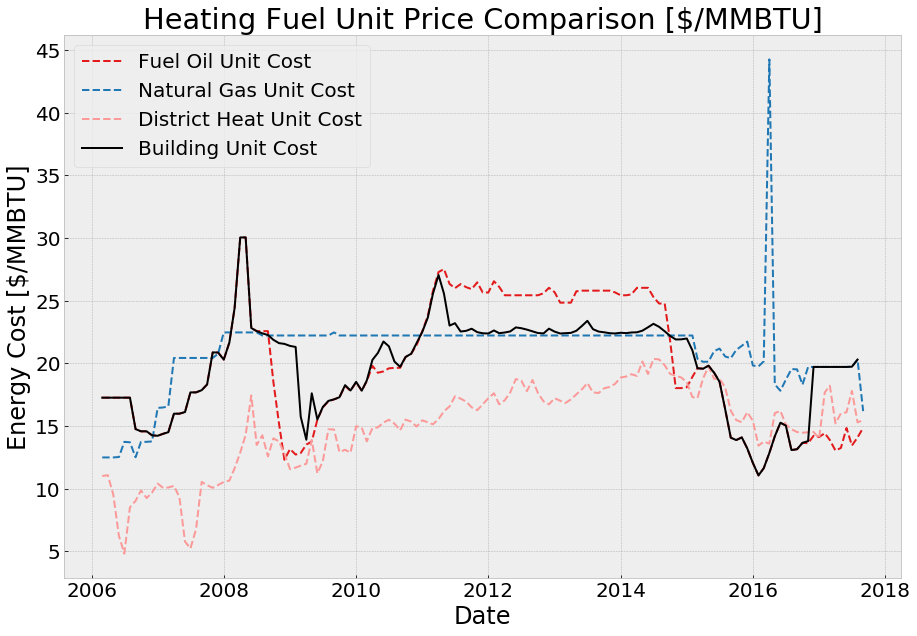

In [158]:
p9g1_filename, p9g1_url = gu.graph_filename_url(site, "energy_cost")
gu.fuel_price_comparison_graph(monthly_heat_energy_and_use, 'date', unit_cost_cols, 'building_unit_cost', p9g1_filename)

## Realized Savings from Fuel Switching: Page 9, Graph 2

In [159]:
monthly_heat_energy_and_use.head()

service_type,fiscal_year,fiscal_mo,Natural Gas Cost,Oil #1 Cost,Steam Cost,total_heating_cost,Natural Gas,Oil #1,Steam,total_heating_energy,fuel_oil_unit_cost,natural_gas_unit_cost,district_heat_unit_cost,building_unit_cost,Natural Gas_avg_unit_cost,Oil #1_avg_unit_cost,Steam_avg_unit_cost,calendar_year,calendar_mo,date
0,2006,9,NaN,109.953450,0.0,109.953450,NaN,6.373421,0.0,6.373421,17.251873,12.480394,11.001751,17.251873,12.480394,14.671069,11.001751,2006,3,2006-03-01
1,2006,10,NaN,286.835088,0.0,286.835088,NaN,16.626316,0.0,16.626316,17.251873,12.480396,11.060005,17.251873,12.480396,15.623967,11.060005,2006,4,2006-04-01
2,2006,11,NaN,296.396257,0.0,296.396257,NaN,17.180526,0.0,17.180526,17.251873,12.480358,9.512712,17.251873,12.480358,17.954684,9.512712,2006,5,2006-05-01
3,2006,12,NaN,286.835088,0.0,286.835088,NaN,16.626316,0.0,16.626316,17.251873,12.512925,6.219821,17.251873,12.512925,17.000551,6.219821,2006,6,2006-06-01
4,2007,1,NaN,296.396257,0.0,296.396257,NaN,17.180526,0.0,17.180526,17.251873,13.725490,4.803764,17.251873,13.725490,13.708584,4.803764,2006,7,2006-07-01


In [160]:
old_usage_cols = ['Natural Gas', 'Oil #1', 'Steam']

In [161]:
# Create an indicator for whether a given heating fuel is available for the facility.  This is done by checking the use for all
# months- if it is zero, then that building doesn't have the option to use that type of fuel.



for col in old_usage_cols:
    new_col_name = col + "_available"
    monthly_heat_energy_and_use[new_col_name] = np.where(monthly_heat_energy_and_use[col].sum() == 0, 0, 1)

monthly_heat_energy_and_use.head()

service_type,fiscal_year,fiscal_mo,Natural Gas Cost,Oil #1 Cost,Steam Cost,total_heating_cost,Natural Gas,Oil #1,Steam,total_heating_energy,...,building_unit_cost,Natural Gas_avg_unit_cost,Oil #1_avg_unit_cost,Steam_avg_unit_cost,calendar_year,calendar_mo,date,Natural Gas_available,Oil #1_available,Steam_available
0,2006,9,NaN,109.953450,0.0,109.953450,NaN,6.373421,0.0,6.373421,...,17.251873,12.480394,14.671069,11.001751,2006,3,2006-03-01,1,1,0
1,2006,10,NaN,286.835088,0.0,286.835088,NaN,16.626316,0.0,16.626316,...,17.251873,12.480396,15.623967,11.060005,2006,4,2006-04-01,1,1,0
2,2006,11,NaN,296.396257,0.0,296.396257,NaN,17.180526,0.0,17.180526,...,17.251873,12.480358,17.954684,9.512712,2006,5,2006-05-01,1,1,0
3,2006,12,NaN,286.835088,0.0,286.835088,NaN,16.626316,0.0,16.626316,...,17.251873,12.512925,17.000551,6.219821,2006,6,2006-06-01,1,1,0
4,2007,1,NaN,296.396257,0.0,296.396257,NaN,17.180526,0.0,17.180526,...,17.251873,13.725490,13.708584,4.803764,2006,7,2006-07-01,1,1,0


In [162]:
# Calculate what it would have cost if the building used only one fuel type

available_cols = ['Oil #1_available','Natural Gas_available','Steam_available']
available_dict = dict(zip(unit_cost_cols, available_cols))
print (available_dict)
hypothetical_cost_cols = []

for unit_cost, avail_col in available_dict.items():
    new_col_name = unit_cost + "_hypothetical"
    hypothetical_cost_cols.append(new_col_name)
    monthly_heat_energy_and_use[new_col_name] = monthly_heat_energy_and_use[unit_cost] * \
    monthly_heat_energy_and_use.total_heating_energy * monthly_heat_energy_and_use[avail_col]
    
monthly_heat_energy_and_use.head()

{'natural_gas_unit_cost': 'Natural Gas_available', 'district_heat_unit_cost': 'Steam_available', 'fuel_oil_unit_cost': 'Oil #1_available'}


service_type,fiscal_year,fiscal_mo,Natural Gas Cost,Oil #1 Cost,Steam Cost,total_heating_cost,Natural Gas,Oil #1,Steam,total_heating_energy,...,Steam_avg_unit_cost,calendar_year,calendar_mo,date,Natural Gas_available,Oil #1_available,Steam_available,natural_gas_unit_cost_hypothetical,district_heat_unit_cost_hypothetical,fuel_oil_unit_cost_hypothetical
0,2006,9,NaN,109.953450,0.0,109.953450,NaN,6.373421,0.0,6.373421,...,11.001751,2006,3,2006-03-01,1,1,0,79.542803,0.0,109.953450
1,2006,10,NaN,286.835088,0.0,286.835088,NaN,16.626316,0.0,16.626316,...,11.060005,2006,4,2006-04-01,1,1,0,207.502997,0.0,286.835088
2,2006,11,NaN,296.396257,0.0,296.396257,NaN,17.180526,0.0,17.180526,...,9.512712,2006,5,2006-05-01,1,1,0,214.419122,0.0,296.396257
3,2006,12,NaN,286.835088,0.0,286.835088,NaN,16.626316,0.0,16.626316,...,6.219821,2006,6,2006-06-01,1,1,0,208.043845,0.0,286.835088
4,2007,1,NaN,296.396257,0.0,296.396257,NaN,17.180526,0.0,17.180526,...,4.803764,2006,7,2006-07-01,1,1,0,235.811146,0.0,296.396257


In [163]:
# Calculate the monthly savings to the building by not using the most expensive available fuel entirely
monthly_heat_energy_and_use['fuel_switching_savings'] = monthly_heat_energy_and_use[hypothetical_cost_cols].max(axis=1) \
                                                        - monthly_heat_energy_and_use.total_heating_cost

In [164]:
# Sort dataframe to calculate cumulative value
monthly_heat_energy_and_use = monthly_heat_energy_and_use.sort_values(by='date', ascending=True)

# Calculate cumulative value
monthly_heat_energy_and_use['cumulative_fuel_switching_savings'] = np.cumsum(monthly_heat_energy_and_use.fuel_switching_savings)

monthly_heat_energy_and_use.head()

service_type,fiscal_year,fiscal_mo,Natural Gas Cost,Oil #1 Cost,Steam Cost,total_heating_cost,Natural Gas,Oil #1,Steam,total_heating_energy,...,calendar_mo,date,Natural Gas_available,Oil #1_available,Steam_available,natural_gas_unit_cost_hypothetical,district_heat_unit_cost_hypothetical,fuel_oil_unit_cost_hypothetical,fuel_switching_savings,cumulative_fuel_switching_savings
0,2006,9,NaN,109.953450,0.0,109.953450,NaN,6.373421,0.0,6.373421,...,3,2006-03-01,1,1,0,79.542803,0.0,109.953450,0.0,0.0
1,2006,10,NaN,286.835088,0.0,286.835088,NaN,16.626316,0.0,16.626316,...,4,2006-04-01,1,1,0,207.502997,0.0,286.835088,0.0,0.0
2,2006,11,NaN,296.396257,0.0,296.396257,NaN,17.180526,0.0,17.180526,...,5,2006-05-01,1,1,0,214.419122,0.0,296.396257,0.0,0.0
3,2006,12,NaN,286.835088,0.0,286.835088,NaN,16.626316,0.0,16.626316,...,6,2006-06-01,1,1,0,208.043845,0.0,286.835088,0.0,0.0
4,2007,1,NaN,296.396257,0.0,296.396257,NaN,17.180526,0.0,17.180526,...,7,2006-07-01,1,1,0,235.811146,0.0,296.396257,0.0,0.0


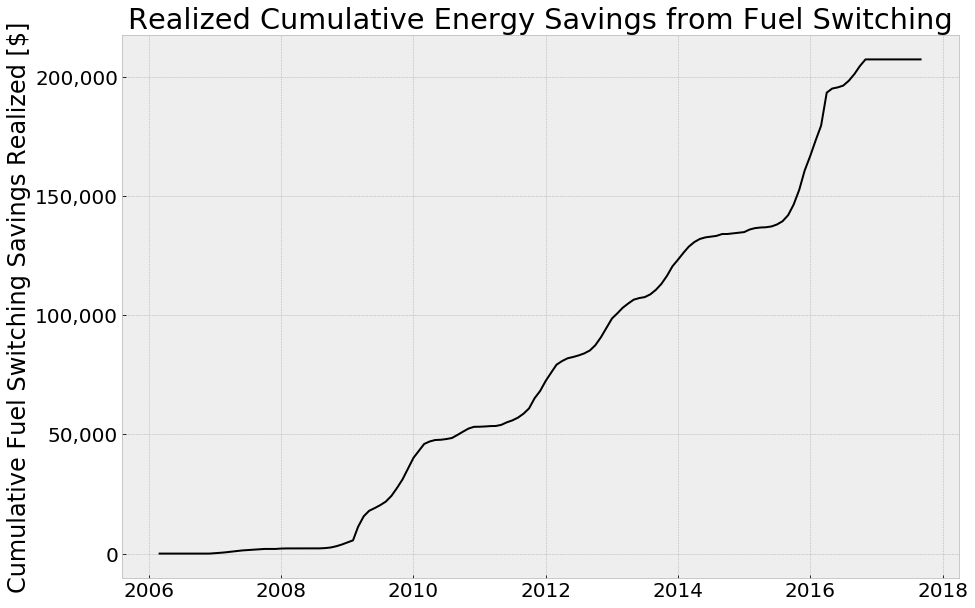

In [165]:
p9g2_filename, p9g2_url = gu.graph_filename_url(site, "cumulative_fuel_switching_savings")
gu.create_monthly_line_graph(monthly_heat_energy_and_use, 'date', 'cumulative_fuel_switching_savings',
                            'Cumulative Fuel Switching Savings Realized [$]', p9g2_filename)

In [166]:
# Convert df to dictionary
heating_cost_rows = bu.df_to_dictionaries(heating_cost_and_use)

# Add data and graphs to main dictionary
template_data['heating_cost_analysis'] = dict(
    graphs=[p9g1_url, p9g2_url],
    table={'rows': heating_cost_rows},
)

# Water Analysis Table - Page 10

In [167]:
water_use = df.query('site_id == @site')[['service_type', 'fiscal_year', 'fiscal_mo','cost', 'usage', 'units']]
water_use.head()

,service_type,fiscal_year,fiscal_mo,cost,usage,units
48636,Electricity,2006,12,1971.105,24960.0,kWh
48637,Electricity,2006,12,931.745,117.0,kW
48638,Electricity,2006,12,621.220,NaN,-
48639,Electricity,2007,1,3736.435,47100.0,kWh
48640,Electricity,2007,1,1863.490,234.0,kW


In [168]:
# Create month count field for all months that have water and sewer bills
water_use_only = water_use.query("service_type == 'Water'")
water_months_present = bu.months_present(water_use_only)
water_mo_count = bu.month_count(water_months_present)
water_mo_count

year
2007     9
2008    12
2009    12
2010    12
2011    12
2012    12
2013    12
2014    12
2015    12
2016    12
2017    12
2018     3
Name: month, dtype: int64

In [169]:
# Create annual water gallon usage dataframe
water_gal_df = pd.pivot_table(water_use, 
                              values='usage',
                              index=['fiscal_year',], 
                              columns=['service_type'],
                              aggfunc=np.sum
)

water_gal_df.head()

service_type,Electricity,Natural Gas,Oil #1,Sewer,Water
fiscal_year,,,,,
2006,2.507700e+04,NaN,420.789474,NaN,NaN
2007,1.194041e+06,NaN,5372.449163,1.712421e+06,1.712421e+06
2008,1.314766e+06,NaN,5455.011364,1.765586e+06,1.765586e+06
2009,1.375791e+06,50973.500000,15648.940476,1.682894e+06,1.682894e+06
2010,1.464370e+06,5551.733333,50955.673160,2.272170e+06,2.272170e+06


In [170]:
# Use only required columns 
water_gal_df = water_gal_df[['Water']]
# Calculate percent change column
water_gal_df['water_use_pct_change'] = water_gal_df.Water.pct_change()

In [177]:
# Create annual water and sewer cost dataframe
water_cost_df = pd.pivot_table(water_use, 
                              values='cost',
                              index=['fiscal_year',], 
                              columns=['service_type'],
                              aggfunc=np.sum
)

water_cost_df.head()

service_type,Electricity,Natural Gas,Oil #1,Sewer,Water
fiscal_year,,,,,
2006,3524.070000,NaN,980.019883,NaN,NaN
2007,150960.622031,NaN,10852.587503,16947.621429,13737.110714
2008,213135.022187,NaN,15560.320114,18513.418866,17242.660168
2009,200554.873496,116398.452000,30202.520595,17648.170849,16545.263403
2010,232795.478576,13314.745167,124264.351905,24156.588500,21808.169107


In [178]:
    # Calculate totals, percent change
    water_cost_df = water_cost_df[water_cost_df.columns.difference(['Electricity', 'Natural Gas', 'Oil #1', 'Steam', 'Refuse'])]
    
    # Rename columns only if they exist in the water cost dataframe
    rename_dict = {'Sewer': 'Sewer Cost',
                   'Water': 'Water Cost'}
    water_cost_df = water_cost_df.rename(columns={k: v for k, v in rename_dict.items() if k in water_cost_df})
    
    # First check to make sure sewer data is included; if so, calculate total cost
    water_cost_df['total_water_sewer_cost'] = np.where('Sewer Cost' in list(water_cost_df.columns.values),
                                                       water_cost_df['Sewer Cost'] + water_cost_df['Water Cost'],
                                                       water_cost_df['Water Cost'])

In [180]:
    water_cost_df['water_cost_pct_change'] = water_cost_df['Water Cost'].pct_change()
                                                       
    # First check to make sure sewer data is included; if so, calculate percent change
    water_cost_df['sewer_cost_pct_change'] = np.where('Sewer Cost' in list(water_cost_df.columns.values),
                                                      water_cost_df['Sewer Cost'].pct_change(),
                                                      np.nan)
                                                       
    water_cost_df['total_water_sewer_cost_pct_change'] = water_cost_df.total_water_sewer_cost.pct_change()

In [173]:
# Merge use and cost dataframes
water_use_and_cost = pd.merge(water_cost_df, water_gal_df, left_index=True, right_index=True, how='outer')
water_use_and_cost.head()

service_type,Sewer Cost,Water Cost,total_water_sewer_cost,water_cost_pct_change,sewer_cost_pct_change,total_water_sewer_cost_pct_change,Water,water_use_pct_change
fiscal_year,,,,,,,,
2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007,16947.621429,13737.110714,30684.732143,NaN,NaN,NaN,1.712421e+06,NaN
2008,18513.418866,17242.660168,35756.079034,0.255188,0.092390,0.165273,1.765586e+06,0.031047
2009,17648.170849,16545.263403,34193.434252,-0.040446,-0.046736,-0.043703,1.682894e+06,-0.046835
2010,24156.588500,21808.169107,45964.757607,0.318091,0.368787,0.344257,2.272170e+06,0.350157


In [174]:
water_use_and_cost['water_unit_cost'] = water_use_and_cost.total_water_sewer_cost / water_use_and_cost.Water
water_use_and_cost['water_unit_cost_pct_change'] = water_use_and_cost.water_unit_cost.pct_change()

# Use only complete years 
water_use_and_cost['month_count'] = water_mo_count
water_use_and_cost = water_use_and_cost.query("month_count == 12")
water_use_and_cost = water_use_and_cost.drop('month_count', axis=1)
water_use_and_cost = water_use_and_cost.sort_index(ascending=False)
water_use_and_cost = water_use_and_cost.rename(columns={'Sewer Cost':'sewer_cost',
                                                       'Water Cost':'water_cost',
                                                       'total_water_sewer_cost':'total_cost',
                                                       'total_water_sewer_cost_pct_change':'total_cost_pct_change',
                                                       'Water':'total_usage',
                                                       'water_usage_pct_change':'total_usage_pct_change',
                                                       'water_unit_cost':'total_unit_cost',
                                                       'water_unit_cost_pct_change':'total_unit_cost_pct_change'
                                                       })
water_use_and_cost

service_type,sewer_cost,water_cost,total_cost,water_cost_pct_change,sewer_cost_pct_change,total_cost_pct_change,total_usage,water_use_pct_change,total_unit_cost,total_unit_cost_pct_change
fiscal_year,,,,,,,,,,
2017,20166.372612,19001.609888,39167.982500,0.059823,0.028483,0.043452,1.606898e+06,0.024049,0.024375,0.018948
2016,19607.886225,17929.045186,37536.931411,-0.042154,0.014424,-0.013411,1.569161e+06,-0.100524,0.023922,0.096849
2015,19329.089516,18718.094839,38047.184355,-0.034700,-0.034224,-0.034458,1.744529e+06,-0.064601,0.021809,0.032225
2014,20014.054124,19390.952860,39405.006984,-0.018030,0.007973,-0.004993,1.865012e+06,0.007831,0.021129,-0.012724
2013,19855.745738,19746.999190,39602.744929,-0.056122,-0.138067,-0.099066,1.850520e+06,-0.009826,0.021401,-0.090126
2012,23036.310714,20921.145357,43957.456071,0.018582,0.021279,0.019994,1.868884e+06,-0.113235,0.023521,0.150241
2011,22556.336071,20539.473393,43095.809464,-0.058175,-0.066245,-0.062416,2.107529e+06,-0.072460,0.020449,0.010828
2010,24156.588500,21808.169107,45964.757607,0.318091,0.368787,0.344257,2.272170e+06,0.350157,0.020229,-0.004370
2009,17648.170849,16545.263403,34193.434252,-0.040446,-0.046736,-0.043703,1.682894e+06,-0.046835,0.020318,0.003287


## Create Water Cost Stacked Bar Graph - Page 10 Graph 1

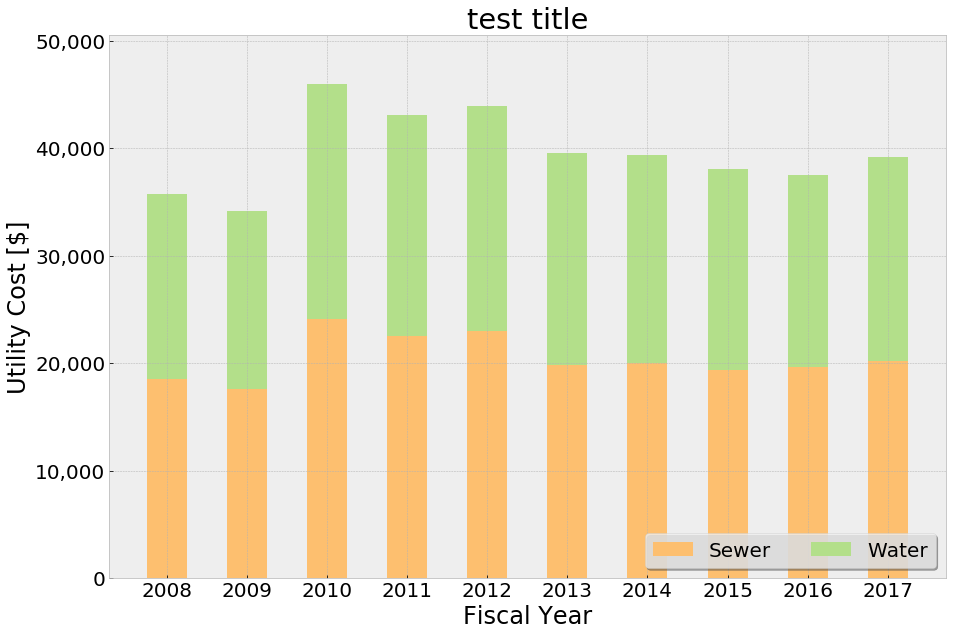

In [176]:
p10g1_filename, p10g1_url = gu.graph_filename_url(site, "utility_cost")
gu.create_stacked_bar(water_use_and_cost.reset_index(), 'fiscal_year', ['sewer_cost', 'water_cost'], 
                      'Utility Cost [$]', "test title", p10g1_filename)

## Create Monthly Profile of Water Usage - Page 10 Graph 2

In [ ]:
# Create monthly water gallon dataframe
water_gal_df_monthly = pd.pivot_table(water_use, 
                              values='usage',
                              index=['fiscal_year', 'fiscal_mo'], 
                              columns=['service_type'],
                              aggfunc=np.sum
)

water_gal_df_monthly.head()

In [ ]:
p10g2_filename, p10g2_url = gu.graph_filename_url(site, "monthly_water_usage_profile")
gu.create_monthly_profile(water_gal_df_monthly, 'Water', 'Monthly Water Usage Profile [gallons]', 'green', p10g2_filename)

In [ ]:
# Convert df to dictionary
water_rows = bu.df_to_dictionaries(water_use_and_cost)

# Add data and graphs to main dictionary
template_data['water_analysis'] = dict(
    graphs=[p10g1_url, p10g2_url],
    table={'rows': water_rows},
)

In [ ]:
template_data